In [129]:
import pandas as pd
import yfinance as yf
from datetime import timedelta
import time
import os
import matplotlib.pyplot as plt
import numpy as np

In [87]:
# Parametry badania
START_DATE = "2005-01-02"
END_DATE = "2025-01-02"

# Pliki
TICKERS_FILE = 'Data/sp500_ticker_start_end.csv'
OUTPUT_FILE = 'Data/price_spikes_with_future_close_final_version.csv'

# Wczytanie tickerów i dat, kiedy spółka była w indeksie S&P500
tickers_df = pd.read_csv(TICKERS_FILE, na_values=['', ' '])
tickers_df['start_date'] = pd.to_datetime(tickers_df['start_date'], errors='coerce')
tickers_df['end_date'] = pd.to_datetime(tickers_df['end_date'], errors='coerce')

# Uzupełnienie brakujących dat
tickers_df['end_date'].fillna(pd.to_datetime(END_DATE), inplace=True)
tickers_df['start_date'].fillna(pd.to_datetime(START_DATE), inplace=True)

# Filtrujemy tylko spółki aktywne w zadanym okresie
tickers_df = tickers_df[
    (tickers_df['end_date'] >= pd.to_datetime(START_DATE)) &
    (tickers_df['start_date'] <= pd.to_datetime(END_DATE))
].reset_index(drop=True)

# Usuwamy plik wynikowy, jeśli istnieje
if os.path.exists(OUTPUT_FILE):
    os.remove(OUTPUT_FILE)

# Funkcja zwracająca najbliższą cenę zamknięcia od daty
def get_future_close(df, current_date, years):
    future_date = current_date + pd.DateOffset(years=years)
    future_row = df[df['Date'] >= future_date]
    return future_row['Close'].iloc[0] if not future_row.empty else None

# Główna pętla po tickerach
for idx, row in tickers_df.iterrows():
    ticker = row['ticker']
    ticker_start = max(row['start_date'], pd.to_datetime(START_DATE))
    ticker_end = min(row['end_date'], pd.to_datetime(END_DATE))
    print(f"Pobieram dane: {ticker} od {ticker_start.date()} do {ticker_end.date()}")

    df = pd.DataFrame()
    for attempt in range(3):
        try:
            df = yf.download(ticker, start=ticker_start, end=ticker_end + timedelta(days=1),
                             progress=False, auto_adjust=False)
            if not df.empty:
                break
            time.sleep(2)
        except Exception as e:
            print(f"Próba {attempt+1} nieudana dla {ticker}: {e}")
            time.sleep(2)

    if df.empty:
        print(f"Brak danych dla {ticker}")
        continue

    # Obsługa MultiIndex kolumn (jeśli występuje)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns.values]

    # Wybór kolumny Close
    close_col = f'Close_{ticker}'
    if close_col not in df.columns:
        if 'Close' in df.columns:
            close_col = 'Close'
        else:
            print(f"Kolumna Close nie znaleziona dla {ticker}")
            continue

    df = df.reset_index()[['Date', close_col]].copy()
    df.rename(columns={close_col: 'Close'}, inplace=True)
    df = df.sort_values('Date').reset_index(drop=True)

    # Obliczamy zmianę procentową (spike)
    df['Close_dayminus1'] = df['Close'].shift(1)
    df['Change'] = (df['Close'] - df['Close_dayminus1']) / df['Close_dayminus1']

    # Filtrujemy spike > 10% (wzrost/spadek)
    spikes = df[df['Change'].abs() > 0.10].copy()
    if spikes.empty:
        continue

    spikes['Ticker'] = ticker

    # Dodajemy ceny zamknięcia za 1, 3 i 5 lat od daty spike’a
    spikes['Close_After_1Y'] = spikes.apply(lambda r: get_future_close(df, r['Date'], 1), axis=1)
    spikes['Close_After_3Y'] = spikes.apply(lambda r: get_future_close(df, r['Date'], 3), axis=1)
    spikes['Close_After_5Y'] = spikes.apply(lambda r: get_future_close(df, r['Date'], 5), axis=1)

    # Zapisujemy do pliku
    header = not os.path.exists(OUTPUT_FILE)
    spikes[['Ticker', 'Date', 'Close', 'Close_dayminus1', 'Change',
            'Close_After_1Y', 'Close_After_3Y', 'Close_After_5Y']].to_csv(OUTPUT_FILE, mode='a', index=False, header=header)

print(f"Przetwarzanie zakończone. Wyniki zapisane w: {OUTPUT_FILE}")

C:\Users\lukas\AppData\Local\Temp\ipykernel_94036\2997518406.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tickers_df['end_date'].fillna(pd.to_datetime(END_DATE), inplace=True)
C:\Users\lukas\AppData\Local\Temp\ipykernel_94036\2997518406.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

Pobieram dane: A od 2005-01-02 do 2025-01-02
Pobieram dane: AABA od 2005-01-02 do 2017-06-19



1 Failed download:
['AABA']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['AABA']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['AABA']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla AABA
Pobieram dane: AAL od 2015-03-23 do 2024-09-23
Pobieram dane: AAP od 2015-07-09 do 2023-08-25
Pobieram dane: AAPL od 2005-01-02 do 2025-01-02
Pobieram dane: ABBV od 2013-01-02 do 2025-01-02
Pobieram dane: ABC od 2005-01-02 do 2023-08-30



1 Failed download:
['ABC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ABC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ABC']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla ABC
Pobieram dane: ABI od 2005-01-02 do 2008-11-24



1 Failed download:
['ABI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-11-25 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1227589200")')

1 Failed download:
['ABI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-11-25 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1227589200")')

1 Failed download:
['ABI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-11-25 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1227589200")')


Brak danych dla ABI
Pobieram dane: ABKFQ od 2005-01-02 do 2008-06-11



1 Failed download:
['ABKFQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ABKFQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ABKFQ']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla ABKFQ
Pobieram dane: ABMD od 2018-05-31 do 2022-12-22



1 Failed download:
['ABMD']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ABMD']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ABMD']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla ABMD
Pobieram dane: ABNB od 2023-09-18 do 2025-01-02
Pobieram dane: ABS od 2005-01-02 do 2006-06-02



1 Failed download:
['ABS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-06-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1149307200")')

1 Failed download:
['ABS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-06-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1149307200")')

1 Failed download:
['ABS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-06-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1149307200")')


Brak danych dla ABS
Pobieram dane: ABT od 2005-01-02 do 2025-01-02
Pobieram dane: ACAS od 2007-07-09 do 2009-03-04



1 Failed download:
['ACAS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-07-09 00:00:00 -> 2009-03-05 00:00:00)')

1 Failed download:
['ACAS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-07-09 00:00:00 -> 2009-03-05 00:00:00)')

1 Failed download:
['ACAS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-07-09 00:00:00 -> 2009-03-05 00:00:00)')


Brak danych dla ACAS
Pobieram dane: ACGL od 2022-11-01 do 2025-01-02
Pobieram dane: ACN od 2011-07-06 do 2025-01-02
Pobieram dane: ACS od 2005-01-02 do 2010-02-08
Pobieram dane: ACV od 2005-01-02 do 2006-11-17



1 Failed download:
['ACV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-11-18 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1163826000")')

1 Failed download:
['ACV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-11-18 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1163826000")')

1 Failed download:
['ACV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-11-18 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1163826000")')


Brak danych dla ACV
Pobieram dane: ADBE od 2005-01-02 do 2025-01-02
Pobieram dane: ADCT od 2005-01-02 do 2007-07-02



1 Failed download:
['ADCT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-07-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1183435200")')

1 Failed download:
['ADCT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-07-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1183435200")')

1 Failed download:
['ADCT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-07-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1183435200")')


Brak danych dla ADCT
Pobieram dane: ADI od 2005-01-02 do 2025-01-02
Pobieram dane: ADM od 2005-01-02 do 2025-01-02
Pobieram dane: ADP od 2005-01-02 do 2025-01-02
Pobieram dane: ADS od 2013-12-23 do 2020-06-22



1 Failed download:
['ADS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ADS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ADS']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla ADS
Pobieram dane: ADSK od 2005-01-02 do 2025-01-02
Pobieram dane: ADT od 2012-10-02 do 2016-05-02



1 Failed download:
['ADT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2012-10-02 00:00:00 -> 2016-05-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1349150400, endDate = 1462248000")')

1 Failed download:
['ADT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2012-10-02 00:00:00 -> 2016-05-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1349150400, endDate = 1462248000")')

1 Failed download:
['ADT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2012-10-02 00:00:00 -> 2016-05-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1349150400, endDate = 1462248000")')


Brak danych dla ADT
Pobieram dane: AEE od 2005-01-02 do 2025-01-02
Pobieram dane: AEP od 2005-01-02 do 2025-01-02
Pobieram dane: AES od 2005-01-02 do 2025-01-02
Pobieram dane: AET od 2005-01-02 do 2018-11-29
Pobieram dane: AFL od 2005-01-02 do 2025-01-02
Pobieram dane: AGN od 2005-01-02 do 2020-05-12



1 Failed download:
['AGN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['AGN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['AGN']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla AGN
Pobieram dane: AIG od 2005-01-02 do 2025-01-02
Pobieram dane: AIV od 2005-01-02 do 2020-12-21
Pobieram dane: AIZ od 2007-04-10 do 2025-01-02
Pobieram dane: AJG od 2016-05-31 do 2025-01-02
Pobieram dane: AKAM od 2007-07-12 do 2025-01-02



1 Failed download:
['AKAM']: Timeout('Failed to perform, curl: (28) Connection timed out after 10007 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Pobieram dane: AKS od 2008-07-01 do 2011-12-19



1 Failed download:
['AKS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['AKS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['AKS']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla AKS
Pobieram dane: ALB od 2016-07-01 do 2025-01-02
Pobieram dane: ALGN od 2017-06-19 do 2025-01-02
Pobieram dane: ALK od 2016-05-13 do 2023-10-18
Pobieram dane: ALL od 2005-01-02 do 2025-01-02
Pobieram dane: ALLE od 2013-12-02 do 2025-01-02
Pobieram dane: ALTR od 2005-01-02 do 2015-12-28



1 Failed download:
['ALTR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ALTR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ALTR']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla ALTR
Pobieram dane: ALXN od 2012-05-25 do 2021-07-21



1 Failed download:
['ALXN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ALXN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ALXN']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla ALXN
Pobieram dane: AMAT od 2005-01-02 do 2025-01-02
Pobieram dane: AMCC od 2005-01-02 do 2006-05-18



1 Failed download:
['AMCC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-05-19 00:00:00)')

1 Failed download:
['AMCC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-05-19 00:00:00)')

1 Failed download:
['AMCC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-05-19 00:00:00)')


Brak danych dla AMCC
Pobieram dane: AMCR od 2019-06-07 do 2025-01-02
Pobieram dane: AMD od 2005-01-02 do 2013-09-23
Pobieram dane: AMD od 2017-03-20 do 2025-01-02
Pobieram dane: AME od 2013-09-23 do 2025-01-02
Pobieram dane: AMG od 2014-07-01 do 2019-12-23
Pobieram dane: AMGN od 2005-01-02 do 2025-01-02
Pobieram dane: AMP od 2005-10-03 do 2025-01-02
Pobieram dane: AMT od 2007-11-19 do 2025-01-02
Pobieram dane: AMTM od 2024-09-30 do 2024-12-23
Pobieram dane: AMZN od 2005-11-21 do 2025-01-02
Pobieram dane: AN od 2005-01-02 do 2017-08-08
Pobieram dane: ANDV od 2007-09-27 do 2018-10-01



1 Failed download:
['ANDW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-10-03 00:00:00)')


Pobieram dane: ANDW od 2005-01-02 do 2006-10-02



1 Failed download:
['ANDW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-10-03 00:00:00)')

1 Failed download:
['ANDW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-10-03 00:00:00)')


Brak danych dla ANDW
Pobieram dane: ANET od 2018-08-28 do 2025-01-02
Pobieram dane: ANF od 2007-03-29 do 2013-12-23
Pobieram dane: ANRZQ od 2011-06-02 do 2012-10-02



1 Failed download:
['ANRZQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-06-02 00:00:00 -> 2012-10-03 00:00:00)')

1 Failed download:
['ANRZQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-06-02 00:00:00 -> 2012-10-03 00:00:00)')

1 Failed download:
['ANRZQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-06-02 00:00:00 -> 2012-10-03 00:00:00)')


Brak danych dla ANRZQ
Pobieram dane: ANSS od 2017-06-19 do 2025-01-02
Pobieram dane: ANTM od 2005-01-02 do 2022-06-28



1 Failed download:
['ANTM']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ANTM']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ANTM']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla ANTM
Pobieram dane: AON od 2005-01-02 do 2025-01-02
Pobieram dane: AOS od 2017-07-26 do 2025-01-02
Pobieram dane: APA od 2005-01-02 do 2025-01-02
Pobieram dane: APC od 2005-01-02 do 2019-08-09



1 Failed download:
['APC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['APC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['APC']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla APC
Pobieram dane: APCC od 2005-01-02 do 2007-02-15



1 Failed download:
['APCC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-02-16 00:00:00)')

1 Failed download:
['APCC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-02-16 00:00:00)')

1 Failed download:
['APCC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-02-16 00:00:00)')


Brak danych dla APCC
Pobieram dane: APD od 2005-01-02 do 2025-01-02
Pobieram dane: APH od 2008-09-30 do 2025-01-02
Pobieram dane: APO od 2024-12-23 do 2025-01-02
Pobieram dane: APOL od 2005-01-02 do 2013-07-01



1 Failed download:
['APOL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2013-07-02 00:00:00)')

1 Failed download:
['APOL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2013-07-02 00:00:00)')

1 Failed download:
['APOL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2013-07-02 00:00:00)')


Brak danych dla APOL
Pobieram dane: APTV od 2012-12-24 do 2025-01-02
Pobieram dane: ARE od 2017-03-20 do 2025-01-02
Pobieram dane: ARG od 2009-09-09 do 2016-05-23



1 Failed download:
['ARG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2009-09-09 00:00:00 -> 2016-05-24 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1252468800, endDate = 1464062400")')

1 Failed download:
['ARG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2009-09-09 00:00:00 -> 2016-05-24 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1252468800, endDate = 1464062400")')

1 Failed download:
['ARG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2009-09-09 00:00:00 -> 2016-05-24 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1252468800, endDate = 1464062400")')


Brak danych dla ARG
Pobieram dane: ARNC od 2005-01-02 do 2020-04-06



1 Failed download:
['ARNC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ARNC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ARNC']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla ARNC
Pobieram dane: ASH od 2005-01-02 do 2008-11-14
Pobieram dane: ASN od 2005-01-02 do 2007-10-08
Pobieram dane: ASO od 2005-01-02 do 2006-11-06



1 Failed download:
['ASO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-11-07 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1162875600")')

1 Failed download:
['ASO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-11-07 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1162875600")')

1 Failed download:
['ASO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-11-07 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1162875600")')


Brak danych dla ASO
Pobieram dane: AT od 2005-01-02 do 2007-11-19



1 Failed download:
['AT']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['AT']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['AT']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla AT
Pobieram dane: ATGE od 2009-06-09 do 2012-10-01
Pobieram dane: ATI od 2005-01-02 do 2015-07-02
Pobieram dane: ATO od 2019-02-15 do 2025-01-02
Pobieram dane: ATVI od 2015-08-31 do 2023-10-18



1 Failed download:
['ATVI']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ATVI']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ATVI']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:


Brak danych dla ATVI
Pobieram dane: AV od 2005-01-02 do 2007-10-26


['AV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-10-27 00:00:00)')

1 Failed download:
['AV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-10-27 00:00:00)')

1 Failed download:
['AV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-10-27 00:00:00)')


Brak danych dla AV
Pobieram dane: AVB od 2007-01-10 do 2025-01-02
Pobieram dane: AVGO od 2014-05-08 do 2025-01-02
Pobieram dane: AVP od 2005-01-02 do 2015-03-23



1 Failed download:
['AVP']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['AVP']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['AVP']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla AVP
Pobieram dane: AVY od 2005-01-02 do 2025-01-02
Pobieram dane: AW od 2005-01-02 do 2008-12-05



1 Failed download:
['AW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-12-06 00:00:00)')

1 Failed download:
['AW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-12-06 00:00:00)')

1 Failed download:
['AW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-12-06 00:00:00)')


Brak danych dla AW
Pobieram dane: AWK od 2016-03-04 do 2025-01-02



1 Failed download:
['AWK']: Timeout('Failed to perform, curl: (28) Operation timed out after 10007 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Pobieram dane: AXON od 2023-05-04 do 2025-01-02
Pobieram dane: AXP od 2005-01-02 do 2025-01-02
Pobieram dane: AYE od 2005-01-02 do 2011-02-28
Pobieram dane: AYI od 2016-05-03 do 2018-06-18
Pobieram dane: AZO od 2005-01-02 do 2025-01-02
Pobieram dane: BA od 2005-01-02 do 2025-01-02
Pobieram dane: BAC od 2005-01-02 do 2025-01-02
Pobieram dane: BALL od 2022-05-10 do 2025-01-02
Pobieram dane: BAX od 2005-01-02 do 2025-01-02
Pobieram dane: BBBY od 2005-01-02 do 2017-07-26



1 Failed download:
['BBT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2019-12-10 00:00:00)')


Pobieram dane: BBT od 2005-01-02 do 2019-12-09



1 Failed download:
['BBT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2019-12-10 00:00:00)')

1 Failed download:
['BBT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2019-12-10 00:00:00)')


Brak danych dla BBT
Pobieram dane: BBWI od 2021-08-03 do 2024-10-01
Pobieram dane: BBY od 2005-01-02 do 2025-01-02
Pobieram dane: BC od 2005-01-02 do 2008-06-23



1 Failed download:
['BCR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2017-12-30 00:00:00)')


Pobieram dane: BCR od 2005-01-02 do 2017-12-29



1 Failed download:
['BCR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2017-12-30 00:00:00)')

1 Failed download:
['BCR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2017-12-30 00:00:00)')


Brak danych dla BCR
Pobieram dane: BDK od 2005-01-02 do 2010-03-15
Pobieram dane: BDX od 2005-01-02 do 2025-01-02
Pobieram dane: BEAM od 2005-01-02 do 2014-05-01



1 Failed download:
['BEAM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2014-05-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1399003200")')

1 Failed download:
['BEAM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2014-05-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1399003200")')

1 Failed download:
['BEAM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2014-05-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1399003200")')


Brak danych dla BEAM
Pobieram dane: BEN od 2005-01-02 do 2025-01-02
Pobieram dane: BF.B od 2005-01-02 do 2025-01-02



1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2025-01-03 00:00:00)')

1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2025-01-03 00:00:00)')

1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2025-01-03 00:00:00)')


Brak danych dla BF.B
Pobieram dane: BG od 2023-03-15 do 2025-01-02
Pobieram dane: BHF od 2017-08-07 do 2019-04-02
Pobieram dane: BHGE od 2005-01-02 do 2019-10-18



1 Failed download:
['BHGE']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BHGE']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BHGE']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla BHGE
Pobieram dane: BIG od 2005-01-02 do 2013-02-14



1 Failed download:
['BIG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2013-02-15 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['BIG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2013-02-15 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['BIG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2013-02-15 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')


Brak danych dla BIG
Pobieram dane: BIIB od 2005-01-02 do 2025-01-02
Pobieram dane: BIO od 2020-06-22 do 2024-09-23
Pobieram dane: BJS od 2005-01-02 do 2010-04-29



1 Failed download:
['BJS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2010-04-30 00:00:00)')

1 Failed download:
['BJS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2010-04-30 00:00:00)')

1 Failed download:
['BJS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2010-04-30 00:00:00)')


Brak danych dla BJS
Pobieram dane: BK od 2005-01-02 do 2025-01-02
Pobieram dane: BKNG od 2009-11-06 do 2025-01-02
Pobieram dane: BKR od 2019-10-18 do 2025-01-02
Pobieram dane: BLDR od 2023-10-18 do 2025-01-02
Pobieram dane: BLK od 2011-04-04 do 2025-01-02
Pobieram dane: BLL od 2005-01-02 do 2022-05-10



1 Failed download:
['BLL']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BLL']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BLL']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla BLL
Pobieram dane: BLS od 2005-01-02 do 2007-01-03
Pobieram dane: BMC od 2005-01-02 do 2013-09-11
Pobieram dane: BMET od 2005-01-02 do 2007-07-12



1 Failed download:
['BMET']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-07-13 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1184299200")')

1 Failed download:
['BMET']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-07-13 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1184299200")')

1 Failed download:
['BMET']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-07-13 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1184299200")')


Brak danych dla BMET
Pobieram dane: BMS od 2005-01-02 do 2014-12-05
Pobieram dane: BMY od 2005-01-02 do 2025-01-02
Pobieram dane: BNI od 2005-01-02 do 2010-02-16



1 Failed download:
['BNI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2010-02-17 00:00:00)')

1 Failed download:
['BNI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2010-02-17 00:00:00)')

1 Failed download:
['BNI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2010-02-17 00:00:00)')


Brak danych dla BNI
Pobieram dane: BOL od 2005-01-02 do 2007-10-29
Pobieram dane: BR od 2005-01-02 do 2006-04-03



1 Failed download:
['BR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-04-04 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1144123200")')

1 Failed download:
['BR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-04-04 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1144123200")')

1 Failed download:
['BR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-04-04 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1144123200")')


Brak danych dla BR
Pobieram dane: BR od 2018-06-18 do 2025-01-02
Pobieram dane: BRCM od 2005-01-02 do 2016-02-01



1 Failed download:
['BRCM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2016-02-02 00:00:00)')

1 Failed download:
['BRCM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2016-02-02 00:00:00)')

1 Failed download:
['BRCM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2016-02-02 00:00:00)')


Brak danych dla BRCM
Pobieram dane: BRK.B od 2010-02-16 do 2025-01-02



1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla BRK.B
Pobieram dane: BRL od 2006-02-27 do 2008-12-23
Pobieram dane: BRO od 2021-09-20 do 2025-01-02
Pobieram dane: BSC od 2005-01-02 do 2008-06-02
Pobieram dane: BSX od 2005-01-02 do 2025-01-02
Pobieram dane: BTUUQ od 2006-11-20 do 2014-09-22



1 Failed download:
['BTUUQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-11-20 00:00:00 -> 2014-09-23 00:00:00)')

1 Failed download:
['BTUUQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-11-20 00:00:00 -> 2014-09-23 00:00:00)')

1 Failed download:
['BTUUQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-11-20 00:00:00 -> 2014-09-23 00:00:00)')


Brak danych dla BTUUQ
Pobieram dane: BUD od 2005-01-02 do 2008-11-18



1 Failed download:
['BUD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-11-19 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1227070800")')

1 Failed download:
['BUD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-11-19 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1227070800")')

1 Failed download:
['BUD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-11-19 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1227070800")')


Brak danych dla BUD
Pobieram dane: BWA od 2011-12-19 do 2025-01-02
Pobieram dane: BX od 2023-09-18 do 2025-01-02



1 Failed download:


Pobieram dane: BXLT od 2015-07-01 do 2016-06-03


['BXLT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-07-01 00:00:00 -> 2016-06-04 00:00:00)')

1 Failed download:
['BXLT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-07-01 00:00:00 -> 2016-06-04 00:00:00)')

1 Failed download:
['BXLT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-07-01 00:00:00 -> 2016-06-04 00:00:00)')


Brak danych dla BXLT
Pobieram dane: BXP od 2006-04-03 do 2025-01-02
Pobieram dane: C od 2005-01-02 do 2025-01-02
Pobieram dane: CA od 2005-01-02 do 2018-11-06



1 Failed download:
['CA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2018-11-07 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1541566800")')

1 Failed download:
['CA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2018-11-07 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1541566800")')

1 Failed download:
['CA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2018-11-07 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1541566800")')


Brak danych dla CA
Pobieram dane: CAG od 2005-01-02 do 2025-01-02
Pobieram dane: CAH od 2005-01-02 do 2025-01-02



1 Failed download:
['CAM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-01-29 00:00:00 -> 2016-04-05 00:00:00)')


Pobieram dane: CAM od 2008-01-29 do 2016-04-04



1 Failed download:
['CAM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-01-29 00:00:00 -> 2016-04-05 00:00:00)')

1 Failed download:
['CAM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-01-29 00:00:00 -> 2016-04-05 00:00:00)')


Brak danych dla CAM
Pobieram dane: CAR od 2005-01-02 do 2006-08-01
Pobieram dane: CARR od 2020-04-03 do 2025-01-02
Pobieram dane: CAT od 2005-01-02 do 2025-01-02
Pobieram dane: CB od 2005-01-02 do 2025-01-02
Pobieram dane: CBE od 2005-01-02 do 2009-09-09
Pobieram dane: CBE od 2011-11-23 do 2012-12-03
Pobieram dane: CBH od 2006-06-06 do 2008-03-31



1 Failed download:
['CBH']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CBH']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CBH']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla CBH
Pobieram dane: CBOE od 2017-03-01 do 2025-01-02
Pobieram dane: CBRE od 2006-11-10 do 2025-01-02
Pobieram dane: CBS od 2005-01-02 do 2019-12-05



1 Failed download:
['CBS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CBS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CBS']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla CBS
Pobieram dane: CBSS od 2005-01-02 do 2007-09-07



1 Failed download:
['CBSS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-09-08 00:00:00)')

1 Failed download:
['CBSS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-09-08 00:00:00)')

1 Failed download:
['CBSS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-09-08 00:00:00)')


Brak danych dla CBSS
Pobieram dane: CCE od 2005-01-02 do 2016-05-31



1 Failed download:
['CCE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2016-06-01 00:00:00)')

1 Failed download:
['CCE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2016-06-01 00:00:00)')

1 Failed download:
['CCE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2016-06-01 00:00:00)')


Brak danych dla CCE
Pobieram dane: CCEP od 2016-01-04 do 2016-05-31
Pobieram dane: CCI od 2012-03-13 do 2025-01-02
Pobieram dane: CCL od 2005-01-02 do 2025-01-02



1 Failed download:


Pobieram dane: CCTYQ od 2005-01-02 do 2008-03-31


['CCTYQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-04-01 00:00:00)')

1 Failed download:
['CCTYQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-04-01 00:00:00)')

1 Failed download:
['CCTYQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-04-01 00:00:00)')


Brak danych dla CCTYQ
Pobieram dane: CCU od 2005-01-02 do 2008-07-31



1 Failed download:
['CCU']: Timeout('Failed to perform, curl: (28) Operation timed out after 10016 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Pobieram dane: CDAY od 2021-09-20 do 2024-02-01



1 Failed download:
['CDAY']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CDAY']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CDAY']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla CDAY
Pobieram dane: CDNS od 2017-09-18 do 2025-01-02
Pobieram dane: CDW od 2019-09-23 do 2025-01-02
Pobieram dane: CE od 2018-12-24 do 2025-01-02
Pobieram dane: CEG od 2005-01-02 do 2012-03-13



1 Failed download:
['CEG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2012-03-14 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1331697600")')

1 Failed download:
['CEG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2012-03-14 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1331697600")')

1 Failed download:
['CEG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2012-03-14 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1331697600")')


Brak danych dla CEG
Pobieram dane: CEG od 2022-02-02 do 2025-01-02
Pobieram dane: CELG od 2006-11-06 do 2019-11-21



1 Failed download:
['CELG']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CELG']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CELG']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla CELG
Pobieram dane: CEPH od 2008-11-17 do 2011-10-14



1 Failed download:
['CEPH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-11-17 00:00:00 -> 2011-10-15 00:00:00)')

1 Failed download:
['CEPH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-11-17 00:00:00 -> 2011-10-15 00:00:00)')

1 Failed download:
['CEPH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-11-17 00:00:00 -> 2011-10-15 00:00:00)')


Brak danych dla CEPH
Pobieram dane: CERN od 2010-04-30 do 2022-06-08



1 Failed download:
['CERN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CERN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CERN']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla CERN
Pobieram dane: CF od 2008-08-27 do 2025-01-02
Pobieram dane: CFC od 2005-01-02 do 2008-07-01
Pobieram dane: CFG od 2016-02-01 do 2025-01-02
Pobieram dane: CFN od 2009-09-01 do 2015-03-17



1 Failed download:
['CFN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2009-09-01 00:00:00 -> 2015-03-18 00:00:00)')

1 Failed download:
['CFN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2009-09-01 00:00:00 -> 2015-03-18 00:00:00)')

1 Failed download:
['CFN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2009-09-01 00:00:00 -> 2015-03-18 00:00:00)')


Brak danych dla CFN
Pobieram dane: CHD od 2015-12-29 do 2025-01-02



1 Failed download:
['CHD']: Timeout('Failed to perform, curl: (28) Operation timed out after 10007 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Pobieram dane: CHIR od 2005-01-02 do 2006-04-20



1 Failed download:
['CHIR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-04-21 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1145592000")')

1 Failed download:
['CHIR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-04-21 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1145592000")')

1 Failed download:
['CHIR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-04-21 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1145592000")')


Brak danych dla CHIR
Pobieram dane: CHK od 2006-03-03 do 2018-03-19



1 Failed download:
['CHK']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CHK']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CHK']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla CHK
Pobieram dane: CHRW od 2007-03-02 do 2025-01-02
Pobieram dane: CHTR od 2016-09-08 do 2025-01-02
Pobieram dane: CI od 2005-01-02 do 2025-01-02
Pobieram dane: CIEN od 2005-01-02 do 2009-12-21
Pobieram dane: CIN od 2005-01-02 do 2006-04-03
Pobieram dane: CINF od 2005-01-02 do 2025-01-02
Pobieram dane: CITGQ od 2005-01-02 do 2009-07-27



1 Failed download:
['CITGQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CITGQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CITGQ']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla CITGQ
Pobieram dane: CL od 2005-01-02 do 2025-01-02
Pobieram dane: CLF od 2009-12-21 do 2014-04-02
Pobieram dane: CLX od 2005-01-02 do 2025-01-02
Pobieram dane: CMA od 2005-01-02 do 2024-06-24
Pobieram dane: CMCSA od 2005-01-02 do 2025-01-02



1 Failed download:
['CMCSK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-09-21 00:00:00 -> 2015-12-15 00:00:00)')


Pobieram dane: CMCSK od 2015-09-21 do 2015-12-14



1 Failed download:
['CMCSK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-09-21 00:00:00 -> 2015-12-15 00:00:00)')

1 Failed download:
['CMCSK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-09-21 00:00:00 -> 2015-12-15 00:00:00)')


Brak danych dla CMCSK
Pobieram dane: CME od 2006-08-11 do 2025-01-02
Pobieram dane: CMG od 2011-04-28 do 2025-01-02
Pobieram dane: CMI od 2005-01-02 do 2025-01-02
Pobieram dane: CMS od 2005-01-02 do 2025-01-02
Pobieram dane: CMVT od 2005-01-02 do 2007-02-01
Pobieram dane: CMX od 2005-01-02 do 2007-03-23



1 Failed download:
['CMX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-03-24 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1174708800")')

1 Failed download:
['CMX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-03-24 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1174708800")')

1 Failed download:
['CMX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-03-24 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1174708800")')


Brak danych dla CMX
Pobieram dane: CNC od 2016-03-30 do 2025-01-02
Pobieram dane: CNP od 2005-01-02 do 2025-01-02
Pobieram dane: CNX od 2006-06-28 do 2016-03-04
Pobieram dane: COF od 2005-01-02 do 2025-01-02
Pobieram dane: COG od 2008-06-23 do 2021-10-04



1 Failed download:
['COG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-06-23 00:00:00 -> 2021-10-05 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['COG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-06-23 00:00:00 -> 2021-10-05 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['COG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-06-23 00:00:00 -> 2021-10-05 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')


Brak danych dla COG
Pobieram dane: COL od 2005-01-02 do 2018-11-27
Pobieram dane: COO od 2016-09-23 do 2025-01-02
Pobieram dane: COP od 2005-01-02 do 2025-01-02
Pobieram dane: COR od 2023-08-30 do 2025-01-02
Pobieram dane: COST od 2005-01-02 do 2025-01-02
Pobieram dane: COTY od 2016-10-03 do 2020-09-21



1 Failed download:


Pobieram dane: COV od 2007-07-02 do 2009-06-05


['COV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-07-02 00:00:00 -> 2009-06-06 00:00:00)')

1 Failed download:
['COV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-07-02 00:00:00 -> 2009-06-06 00:00:00)')

1 Failed download:
['COV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-07-02 00:00:00 -> 2009-06-06 00:00:00)')


Brak danych dla COV
Pobieram dane: COV od 2011-03-01 do 2015-01-27
Pobieram dane: CPAY od 2024-03-25 do 2025-01-02
Pobieram dane: CPB od 2005-01-02 do 2025-01-02
Pobieram dane: CPGX od 2015-07-02 do 2016-07-01



1 Failed download:
['CPGX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-07-02 00:00:00 -> 2016-07-02 00:00:00)')

1 Failed download:
['CPGX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-07-02 00:00:00 -> 2016-07-02 00:00:00)')

1 Failed download:
['CPGX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-07-02 00:00:00 -> 2016-07-02 00:00:00)')


Brak danych dla CPGX
Pobieram dane: CPNLQ od 2005-01-02 do 2005-12-02



1 Failed download:
['CPNLQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CPNLQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CPNLQ']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla CPNLQ
Pobieram dane: CPRI od 2016-01-04 do 2020-05-12
Pobieram dane: CPRT od 2018-07-02 do 2025-01-02
Pobieram dane: CPT od 2022-04-04 do 2025-01-02
Pobieram dane: CPWR od 2005-01-02 do 2012-01-03
Pobieram dane: CRL od 2021-05-14 do 2025-01-02
Pobieram dane: CRM od 2008-09-15 do 2025-01-02
Pobieram dane: CRWD od 2024-06-24 do 2025-01-02
Pobieram dane: CSCO od 2005-01-02 do 2025-01-02
Pobieram dane: CSGP od 2022-09-19 do 2025-01-02
Pobieram dane: CSRA od 2015-11-30 do 2018-04-04
Pobieram dane: CSX od 2005-01-02 do 2025-01-02
Pobieram dane: CTAS od 2005-01-02 do 2025-01-02
Pobieram dane: CTB od 2005-01-02 do 2006-07-18



1 Failed download:
['CTB']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CTB']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CTB']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla CTB
Pobieram dane: CTL od 2005-01-02 do 2020-09-18



1 Failed download:
['CTL']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CTL']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CTL']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla CTL
Pobieram dane: CTLT od 2020-09-21 do 2024-12-23



1 Failed download:
['CTLT']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CTLT']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CTLT']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla CTLT
Pobieram dane: CTRA od 2021-10-04 do 2025-01-02
Pobieram dane: CTSH od 2006-11-17 do 2025-01-02
Pobieram dane: CTVA od 2019-06-03 do 2025-01-02
Pobieram dane: CTX od 2005-01-02 do 2009-08-19



1 Failed download:
['CTX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-08-20 00:00:00)')

1 Failed download:
['CTX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-08-20 00:00:00)')

1 Failed download:
['CTX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-08-20 00:00:00)')


Brak danych dla CTX
Pobieram dane: CTXS od 2005-01-02 do 2022-10-03



1 Failed download:
['CTXS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CTXS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CTXS']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla CTXS
Pobieram dane: CVC od 2010-12-20 do 2016-06-21



1 Failed download:
['CVC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-12-20 00:00:00 -> 2016-06-22 00:00:00)')

1 Failed download:
['CVC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-12-20 00:00:00 -> 2016-06-22 00:00:00)')

1 Failed download:
['CVC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-12-20 00:00:00 -> 2016-06-22 00:00:00)')


Brak danych dla CVC
Pobieram dane: CVG od 2005-01-02 do 2009-12-21
Pobieram dane: CVH od 2005-08-30 do 2013-05-07



1 Failed download:
['CVH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-08-30 00:00:00 -> 2013-05-08 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1125374400, endDate = 1367985600")')

1 Failed download:
['CVH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-08-30 00:00:00 -> 2013-05-08 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1125374400, endDate = 1367985600")')

1 Failed download:
['CVH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-08-30 00:00:00 -> 2013-05-08 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1125374400, endDate = 1367985600")')


Brak danych dla CVH
Pobieram dane: CVS od 2005-01-02 do 2025-01-02
Pobieram dane: CVX od 2005-01-02 do 2025-01-02
Pobieram dane: CXO od 2016-02-22 do 2021-01-21



1 Failed download:
['CXO']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CXO']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CXO']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla CXO
Pobieram dane: CZR od 2021-03-22 do 2025-01-02
Pobieram dane: D od 2005-01-02 do 2025-01-02



1 Failed download:
['D']: Timeout('Failed to perform, curl: (28) Operation timed out after 10008 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Pobieram dane: DAL od 2013-09-11 do 2025-01-02
Pobieram dane: DALRQ od 2005-01-02 do 2005-08-19



1 Failed download:
['DALRQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DALRQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DALRQ']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla DALRQ
Pobieram dane: DAY od 2024-02-01 do 2025-01-02
Pobieram dane: DCNAQ od 2005-01-02 do 2006-03-03



1 Failed download:
['DCNAQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DCNAQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DCNAQ']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla DCNAQ
Pobieram dane: DD od 2005-01-02 do 2017-09-01
Pobieram dane: DD od 2019-06-03 do 2025-01-02
Pobieram dane: DDR od 2007-03-23 do 2009-03-30
Pobieram dane: DDS od 2005-01-02 do 2008-10-22
Pobieram dane: DE od 2005-01-02 do 2025-01-02
Pobieram dane: DECK od 2024-03-18 do 2025-01-02
Pobieram dane: DELL od 2005-01-02 do 2013-10-29



1 Failed download:
['DELL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2013-10-30 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1383105600")')

1 Failed download:
['DELL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2013-10-30 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1383105600")')

1 Failed download:
['DELL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2013-10-30 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1383105600")')


Brak danych dla DELL
Pobieram dane: DELL od 2024-09-23 do 2025-01-02
Pobieram dane: DF od 2006-04-03 do 2013-05-24



1 Failed download:
['DF']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DF']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DF']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla DF
Pobieram dane: DFS od 2007-07-02 do 2025-01-02



1 Failed download:
['DFS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DFS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DFS']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla DFS
Pobieram dane: DG od 2005-01-02 do 2007-07-09



1 Failed download:
['DG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-07-10 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1184040000")')

1 Failed download:
['DG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-07-10 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1184040000")')

1 Failed download:
['DG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-07-10 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1184040000")')


Brak danych dla DG
Pobieram dane: DG od 2012-12-03 do 2025-01-02
Pobieram dane: DGX od 2005-01-02 do 2025-01-02
Pobieram dane: DHI od 2005-07-05 do 2025-01-02
Pobieram dane: DHR od 2005-01-02 do 2025-01-02
Pobieram dane: DIS od 2005-01-02 do 2025-01-02
Pobieram dane: DISCA od 2010-03-01 do 2022-04-11



1 Failed download:
['DISCA']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DISCA']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DISCA']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla DISCA
Pobieram dane: DISCK od 2014-08-07 do 2022-04-11



1 Failed download:
['DISCK']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DISCK']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DISCK']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla DISCK
Pobieram dane: DISH od 2017-03-13 do 2023-06-20



1 Failed download:
['DISH']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DISH']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DISH']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla DISH
Pobieram dane: DJ od 2005-01-02 do 2007-12-14



1 Failed download:
['DJ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-12-15 00:00:00)')

1 Failed download:
['DJ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-12-15 00:00:00)')

1 Failed download:
['DJ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-12-15 00:00:00)')


Brak danych dla DJ
Pobieram dane: DLR od 2016-05-18 do 2025-01-02
Pobieram dane: DLTR od 2011-12-19 do 2025-01-02
Pobieram dane: DNB od 2008-12-02 do 2017-04-05



1 Failed download:
['DNB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-12-02 00:00:00 -> 2017-04-06 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1228194000, endDate = 1491451200")')

1 Failed download:
['DNB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-12-02 00:00:00 -> 2017-04-06 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1228194000, endDate = 1491451200")')

1 Failed download:
['DNB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-12-02 00:00:00 -> 2017-04-06 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1228194000, endDate = 1491451200")')


Brak danych dla DNB
Pobieram dane: DNR od 2009-04-02 do 2015-03-23



1 Failed download:
['DNR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DNR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DNR']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla DNR
Pobieram dane: DO od 2009-02-26 do 2016-10-03



1 Failed download:
['DO']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DO']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DO']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla DO
Pobieram dane: DOC od 2024-03-04 do 2025-01-02
Pobieram dane: DOV od 2005-01-02 do 2025-01-02
Pobieram dane: DOW od 2005-01-02 do 2017-09-01



1 Failed download:
['DOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2017-09-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1504324800")')

1 Failed download:
['DOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2017-09-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1504324800")')

1 Failed download:
['DOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2017-09-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1504324800")')


Brak danych dla DOW
Pobieram dane: DOW od 2019-04-02 do 2025-01-02
Pobieram dane: DPHIQ od 2005-01-02 do 2005-10-11



1 Failed download:
['DPHIQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DPHIQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DPHIQ']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla DPHIQ
Pobieram dane: DPZ od 2020-05-12 do 2025-01-02
Pobieram dane: DRE od 2017-07-26 do 2022-10-03



1 Failed download:
['DRE']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DRE']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DRE']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla DRE
Pobieram dane: DRI od 2005-01-02 do 2025-01-02
Pobieram dane: DTE od 2005-01-02 do 2025-01-02
Pobieram dane: DTV od 2006-12-04 do 2015-07-27



1 Failed download:
['DTV']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DTV']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DTV']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla DTV
Pobieram dane: DUK od 2005-01-02 do 2025-01-02
Pobieram dane: DVA od 2008-07-31 do 2025-01-02
Pobieram dane: DVN od 2005-01-02 do 2025-01-02
Pobieram dane: DWDP od 2017-09-01 do 2019-06-03



1 Failed download:
['DWDP']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DWDP']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['DWDP']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla DWDP
Pobieram dane: DXC od 2005-01-02 do 2015-12-01
Pobieram dane: DXC od 2017-04-04 do 2023-10-02
Pobieram dane: DXCM od 2020-05-12 do 2025-01-02
Pobieram dane: DYN od 2005-01-02 do 2009-12-21



1 Failed download:
['DYN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-12-22 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1261458000")')

1 Failed download:
['DYN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-12-22 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1261458000")')

1 Failed download:
['DYN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-12-22 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1261458000")')


Brak danych dla DYN
Pobieram dane: EA od 2005-01-02 do 2025-01-02
Pobieram dane: EBAY od 2005-01-02 do 2025-01-02
Pobieram dane: EC od 2005-01-02 do 2006-06-06



1 Failed download:
['EC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-06-07 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1149652800")')

1 Failed download:
['EC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-06-07 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1149652800")')

1 Failed download:
['EC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-06-07 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1149652800")')


Brak danych dla EC
Pobieram dane: ECL od 2005-01-02 do 2025-01-02
Pobieram dane: ED od 2005-01-02 do 2025-01-02



1 Failed download:
['EDS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-08-27 00:00:00)')


Pobieram dane: EDS od 2005-01-02 do 2008-08-26



1 Failed download:
['EDS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-08-27 00:00:00)')

1 Failed download:
['EDS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-08-27 00:00:00)')


Brak danych dla EDS
Pobieram dane: EFX od 2005-01-02 do 2025-01-02
Pobieram dane: EG od 2023-06-10 do 2025-01-02
Pobieram dane: EIX od 2005-01-02 do 2025-01-02
Pobieram dane: EKDKQ od 2005-01-02 do 2010-12-20



1 Failed download:
['EKDKQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['EKDKQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['EKDKQ']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla EKDKQ
Pobieram dane: EL od 2006-01-05 do 2025-01-02
Pobieram dane: ELV od 2022-06-28 do 2025-01-02
Pobieram dane: EMC od 2005-01-02 do 2016-09-07



1 Failed download:
['EMC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2016-09-08 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1473307200")')

1 Failed download:
['EMC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2016-09-08 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1473307200")')

1 Failed download:
['EMC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2016-09-08 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1473307200")')


Brak danych dla EMC
Pobieram dane: EMN od 2005-01-02 do 2025-01-02



1 Failed download:
['EMN']: Timeout('Failed to perform, curl: (28) Operation timed out after 10003 milliseconds with 5981 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Pobieram dane: EMR od 2005-01-02 do 2025-01-02
Pobieram dane: ENDP od 2015-01-27 do 2017-03-02



1 Failed download:
['ENDP']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ENDP']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ENDP']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla ENDP
Pobieram dane: ENPH od 2021-01-07 do 2025-01-02
Pobieram dane: EOG od 2005-01-02 do 2025-01-02
Pobieram dane: EOP od 2005-01-02 do 2007-02-12



1 Failed download:
['EOP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-02-13 00:00:00)')

1 Failed download:
['EOP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-02-13 00:00:00)')

1 Failed download:
['EOP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-02-13 00:00:00)')


Brak danych dla EOP
Pobieram dane: EP od 2005-01-02 do 2012-05-25
Pobieram dane: EPAM od 2021-12-14 do 2025-01-02
Pobieram dane: EQ od 2006-05-18 do 2009-07-01



1 Failed download:
['EQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-05-18 00:00:00 -> 2009-07-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1147924800, endDate = 1246507200")')

1 Failed download:
['EQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-05-18 00:00:00 -> 2009-07-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1147924800, endDate = 1246507200")')

1 Failed download:
['EQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-05-18 00:00:00 -> 2009-07-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1147924800, endDate = 1246507200")')


Brak danych dla EQ
Pobieram dane: EQIX od 2015-03-23 do 2025-01-02
Pobieram dane: EQR od 2005-01-02 do 2025-01-02
Pobieram dane: EQT od 2008-12-19 do 2018-11-13



1 Failed download:
['EQT']: Timeout('Failed to perform, curl: (28) Connection timed out after 10014 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Pobieram dane: EQT od 2022-10-03 do 2025-01-02



1 Failed download:
['EQT']: Timeout('Failed to perform, curl: (28) Connection timed out after 10017 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Pobieram dane: ERIE od 2024-09-23 do 2025-01-02
Pobieram dane: ES od 2009-03-17 do 2025-01-02
Pobieram dane: ESRX od 2005-01-02 do 2018-12-21
Pobieram dane: ESS od 2014-04-02 do 2025-01-02
Pobieram dane: ESV od 2007-01-04 do 2009-12-23



1 Failed download:
['ESV']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ESV']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ESV']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ESV']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla ESV
Pobieram dane: ESV od 2012-07-31 do 2016-03-30



1 Failed download:
['ESV']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ESV']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla ESV
Pobieram dane: ETFC od 2005-01-02 do 2020-10-07



1 Failed download:
['ETFC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ETFC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ETFC']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla ETFC
Pobieram dane: ETN od 2005-01-02 do 2025-01-02
Pobieram dane: ETR od 2005-01-02 do 2025-01-02
Pobieram dane: ETSY od 2020-09-21 do 2024-09-23
Pobieram dane: EVHC od 2016-12-02 do 2018-10-11
Pobieram dane: EVRG od 2018-06-05 do 2025-01-02
Pobieram dane: EW od 2011-04-01 do 2025-01-02
Pobieram dane: EXC od 2005-01-02 do 2025-01-02
Pobieram dane: EXPD od 2007-10-10 do 2025-01-02
Pobieram dane: EXPE od 2007-10-02 do 2025-01-02
Pobieram dane: EXR od 2016-01-19 do 2025-01-02
Pobieram dane: F od 2005-01-02 do 2025-01-02
Pobieram dane: FANG od 2018-12-03 do 2025-01-02
Pobieram dane: FAST od 2008-09-15 do 2025-01-02
Pobieram dane: FB od 2013-12-23 do 2022-06-09



1 Failed download:
['FB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-12-23 00:00:00 -> 2022-06-10 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1387774800, endDate = 1654833600")')

1 Failed download:
['FB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-12-23 00:00:00 -> 2022-06-10 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1387774800, endDate = 1654833600")')

1 Failed download:
['FB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-12-23 00:00:00 -> 2022-06-10 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1387774800, endDate = 1654833600")')


Brak danych dla FB
Pobieram dane: FBHS od 2016-06-24 do 2022-12-19



1 Failed download:
['FBHS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['FBHS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['FBHS']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla FBHS
Pobieram dane: FCPT od 2015-11-10 do 2015-11-17
Pobieram dane: FCX od 2005-01-02 do 2025-01-02
Pobieram dane: FDC od 2005-01-02 do 2007-09-25



1 Failed download:
['FDC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['FDC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['FDC']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla FDC
Pobieram dane: FDO od 2005-01-02 do 2015-07-07



1 Failed download:
['FDO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2015-07-08 00:00:00)')

1 Failed download:
['FDO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2015-07-08 00:00:00)')

1 Failed download:
['FDO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2015-07-08 00:00:00)')


Brak danych dla FDO
Pobieram dane: FDS od 2021-12-20 do 2025-01-02
Pobieram dane: FDX od 2005-01-02 do 2025-01-02
Pobieram dane: FE od 2005-01-02 do 2025-01-02
Pobieram dane: FFIV od 2010-12-20 do 2025-01-02
Pobieram dane: FHN od 2005-01-02 do 2013-06-24
Pobieram dane: FI od 2023-06-07 do 2025-01-02
Pobieram dane: FICO od 2023-03-20 do 2025-01-02
Pobieram dane: FII od 2005-01-02 do 2013-01-02



1 Failed download:
['FII']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['FII']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['FII']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla FII
Pobieram dane: FIS od 2006-11-10 do 2025-01-02
Pobieram dane: FISV od 2005-01-02 do 2023-06-07



1 Failed download:
['FISV']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['FISV']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['FISV']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla FISV
Pobieram dane: FITB od 2005-01-02 do 2025-01-02
Pobieram dane: FL od 2016-04-04 do 2019-08-09
Pobieram dane: FLIR od 2009-01-02 do 2021-05-14



1 Failed download:
['FLIR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['FLIR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['FLIR']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla FLIR
Pobieram dane: FLR od 2005-01-02 do 2019-06-03
Pobieram dane: FLS od 2008-10-02 do 2021-03-22
Pobieram dane: FLT od 2018-06-20 do 2024-03-25



1 Failed download:
['FLT']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['FLT']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['FLT']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla FLT
Pobieram dane: FMC od 2009-08-19 do 2025-01-02
Pobieram dane: FMCC od 2005-01-02 do 2008-09-11
Pobieram dane: FNMA od 2005-01-02 do 2008-09-11
Pobieram dane: FOSL od 2012-04-04 do 2016-01-05
Pobieram dane: FOX od 2015-09-21 do 2025-01-02
Pobieram dane: FOXA od 2005-01-02 do 2025-01-02
Pobieram dane: FRC od 2019-01-02 do 2023-05-04



1 Failed download:
['FRC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-01-02 00:00:00 -> 2023-05-05 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['FRC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-01-02 00:00:00 -> 2023-05-05 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['FRC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-01-02 00:00:00 -> 2023-05-05 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')


Brak danych dla FRC
Pobieram dane: FRT od 2016-02-01 do 2025-01-02
Pobieram dane: FRX od 2005-01-02 do 2014-07-01



1 Failed download:
['FRX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2014-07-02 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['FRX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2014-07-02 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['FRX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2014-07-02 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')


Brak danych dla FRX
Pobieram dane: FSH od 2005-01-02 do 2006-11-10



1 Failed download:
['FSH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-11-11 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1163221200")')

1 Failed download:
['FSH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-11-11 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1163221200")')

1 Failed download:
['FSH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-11-11 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1163221200")')


Brak danych dla FSH
Pobieram dane: FSL od 2005-01-02 do 2006-12-04



1 Failed download:
['FSL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-12-05 00:00:00)')

1 Failed download:
['FSL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-12-05 00:00:00)')

1 Failed download:
['FSL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-12-05 00:00:00)')


Brak danych dla FSL
Pobieram dane: FSLR od 2009-10-16 do 2017-03-20
Pobieram dane: FSLR od 2022-12-19 do 2025-01-02
Pobieram dane: FTI od 2009-06-05 do 2021-02-12
Pobieram dane: FTNT od 2018-10-11 do 2025-01-02
Pobieram dane: FTR od 2005-01-02 do 2017-03-20



1 Failed download:
['FTR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['FTR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['FTR']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla FTR
Pobieram dane: FTV od 2016-07-05 do 2025-01-02
Pobieram dane: G od 2005-01-02 do 2005-10-03



1 Failed download:
['G']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-10-04 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1128398400")')

1 Failed download:
['G']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-10-04 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1128398400")')

1 Failed download:
['G']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-10-04 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1128398400")')


Brak danych dla G
Pobieram dane: GAS od 2005-01-02 do 2011-12-12



1 Failed download:
['GAS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-12-13 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1323752400")')

1 Failed download:
['GAS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-12-13 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1323752400")')

1 Failed download:
['GAS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-12-13 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1323752400")')


Brak danych dla GAS
Pobieram dane: GAS od 2011-12-13 do 2016-07-01
Pobieram dane: GD od 2005-01-02 do 2025-01-02
Pobieram dane: GDDY od 2024-06-24 do 2025-01-02
Pobieram dane: GDT od 2005-01-02 do 2006-04-24



1 Failed download:
['GDT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-04-25 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1145937600")')

1 Failed download:
['GDT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-04-25 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1145937600")')

1 Failed download:
['GDT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-04-25 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1145937600")')


Brak danych dla GDT
Pobieram dane: GDW od 2005-01-02 do 2006-10-02
Pobieram dane: GE od 2005-01-02 do 2025-01-02
Pobieram dane: GEHC od 2023-01-04 do 2025-01-02
Pobieram dane: GEN od 2022-11-08 do 2025-01-02



1 Failed download:
['GENZ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-04-05 00:00:00)')


Pobieram dane: GENZ od 2005-01-02 do 2011-04-04



1 Failed download:
['GENZ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-04-05 00:00:00)')

1 Failed download:
['GENZ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-04-05 00:00:00)')


Brak danych dla GENZ
Pobieram dane: GEV od 2024-04-03 do 2025-01-02
Pobieram dane: GGP od 2007-07-02 do 2008-11-13



1 Failed download:
['GGP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-07-02 00:00:00 -> 2008-11-14 00:00:00)')

1 Failed download:
['GGP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-07-02 00:00:00 -> 2008-11-14 00:00:00)')

1 Failed download:
['GGP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-07-02 00:00:00 -> 2008-11-14 00:00:00)')


Brak danych dla GGP
Pobieram dane: GGP od 2013-12-10 do 2018-08-28



1 Failed download:
['GGP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-12-10 00:00:00 -> 2018-08-29 00:00:00)')

1 Failed download:
['GGP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-12-10 00:00:00 -> 2018-08-29 00:00:00)')

1 Failed download:
['GGP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-12-10 00:00:00 -> 2018-08-29 00:00:00)')


Brak danych dla GGP
Pobieram dane: GHC od 2007-12-31 do 2014-09-22
Pobieram dane: GILD od 2005-01-02 do 2025-01-02
Pobieram dane: GIS od 2005-01-02 do 2025-01-02
Pobieram dane: GL od 2019-08-08 do 2025-01-02
Pobieram dane: GLK od 2005-01-02 do 2005-07-05
Pobieram dane: GLW od 2005-01-02 do 2025-01-02
Pobieram dane: GM od 2013-06-07 do 2025-01-02
Pobieram dane: GMCR od 2014-03-24 do 2016-03-03



1 Failed download:
['GMCR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2014-03-24 00:00:00 -> 2016-03-04 00:00:00)')

1 Failed download:
['GMCR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2014-03-24 00:00:00 -> 2016-03-04 00:00:00)')

1 Failed download:
['GMCR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2014-03-24 00:00:00 -> 2016-03-04 00:00:00)')


Brak danych dla GMCR
Pobieram dane: GME od 2007-12-14 do 2016-04-25
Pobieram dane: GNRC od 2021-03-22 do 2025-01-02
Pobieram dane: GNW od 2005-12-02 do 2015-11-18
Pobieram dane: GOOG od 2014-04-03 do 2025-01-02
Pobieram dane: GOOGL od 2006-04-03 do 2025-01-02
Pobieram dane: GP od 2005-01-02 do 2005-12-20



1 Failed download:
['GP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-12-21 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1135141200")')

1 Failed download:
['GP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-12-21 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1135141200")')

1 Failed download:
['GP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-12-21 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1135141200")')


Brak danych dla GP
Pobieram dane: GPC od 2005-01-02 do 2025-01-02
Pobieram dane: GPN od 2016-04-25 do 2025-01-02
Pobieram dane: GPS od 2005-01-02 do 2022-02-02



1 Failed download:
['GPS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['GPS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['GPS']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla GPS
Pobieram dane: GR od 2005-01-02 do 2012-07-27
Pobieram dane: GRMN od 2012-12-12 do 2025-01-02
Pobieram dane: GS od 2005-01-02 do 2025-01-02
Pobieram dane: GT od 2005-01-02 do 2019-02-27



1 Failed download:
['GTW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-08-02 00:00:00)')


Pobieram dane: GTW od 2005-01-02 do 2006-08-01



1 Failed download:
['GTW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-08-02 00:00:00)')

1 Failed download:
['GTW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-08-02 00:00:00)')


Brak danych dla GTW
Pobieram dane: GWW od 2005-01-02 do 2025-01-02
Pobieram dane: H od 2006-08-01 do 2007-04-10



1 Failed download:
['H']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-08-01 00:00:00 -> 2007-04-11 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1154404800, endDate = 1176264000")')

1 Failed download:
['H']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-08-01 00:00:00 -> 2007-04-11 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1154404800, endDate = 1176264000")')

1 Failed download:
['H']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-08-01 00:00:00 -> 2007-04-11 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1154404800, endDate = 1176264000")')


Brak danych dla H
Pobieram dane: HAL od 2005-01-02 do 2025-01-02
Pobieram dane: HAR od 2006-02-01 do 2017-03-13
Pobieram dane: HAS od 2005-01-02 do 2025-01-02
Pobieram dane: HBAN od 2005-01-02 do 2025-01-02
Pobieram dane: HBI od 2015-03-23 do 2021-12-20
Pobieram dane: HCA od 2005-01-02 do 2006-11-20



1 Failed download:
['HCA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-11-21 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1164085200")')

1 Failed download:
['HCA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-11-21 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1164085200")')

1 Failed download:
['HCA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-11-21 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1164085200")')


Brak danych dla HCA
Pobieram dane: HCA od 2015-01-27 do 2025-01-02
Pobieram dane: HCBK od 2007-02-15 do 2015-11-02



1 Failed download:
['HCBK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-02-15 00:00:00 -> 2015-11-03 00:00:00)')

1 Failed download:
['HCBK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-02-15 00:00:00 -> 2015-11-03 00:00:00)')

1 Failed download:
['HCBK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-02-15 00:00:00 -> 2015-11-03 00:00:00)')


Brak danych dla HCBK
Pobieram dane: HCP od 2008-03-31 do 2019-11-05



1 Failed download:
['HCP']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['HCP']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['HCP']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla HCP
Pobieram dane: HCR od 2005-01-02 do 2007-11-09



1 Failed download:
['HCR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['HCR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['HCR']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla HCR
Pobieram dane: HD od 2005-01-02 do 2025-01-02
Pobieram dane: HES od 2005-01-02 do 2025-01-02
Pobieram dane: HET od 2005-01-02 do 2008-01-29
Pobieram dane: HFC od 2018-06-18 do 2021-06-04



1 Failed download:
['HFC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['HFC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['HFC']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla HFC
Pobieram dane: HIG od 2005-01-02 do 2025-01-02
Pobieram dane: HII od 2018-01-03 do 2025-01-02
Pobieram dane: HLT od 2005-01-02 do 2007-10-25



1 Failed download:
['HLT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-10-26 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1193371200")')

1 Failed download:
['HLT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-10-26 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1193371200")')

1 Failed download:
['HLT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-10-26 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1193371200")')


Brak danych dla HLT
Pobieram dane: HLT od 2017-06-19 do 2025-01-02
Pobieram dane: HMA od 2005-01-02 do 2007-03-02



1 Failed download:
['HMA']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['HMA']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['HMA']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla HMA
Pobieram dane: HNZ od 2005-01-02 do 2013-06-07
Pobieram dane: HOG od 2005-01-02 do 2020-06-22
Pobieram dane: HOLX od 2016-03-30 do 2025-01-02
Pobieram dane: HON od 2005-01-02 do 2025-01-02
Pobieram dane: HOT od 2005-01-02 do 2016-09-23
Pobieram dane: HP od 2010-03-01 do 2020-05-22
Pobieram dane: HPC od 2005-01-02 do 2008-11-14
Pobieram dane: HPE od 2015-11-02 do 2025-01-02
Pobieram dane: HPQ od 2005-01-02 do 2025-01-02
Pobieram dane: HRB od 2005-01-02 do 2020-09-21
Pobieram dane: HRL od 2009-03-04 do 2025-01-02
Pobieram dane: HRS od 2008-09-22 do 2019-06-01



1 Failed download:
['HRS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['HRS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['HRS']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla HRS
Pobieram dane: HSH od 2005-01-02 do 2012-06-29



1 Failed download:
['HSH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2012-06-30 00:00:00)')

1 Failed download:
['HSH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2012-06-30 00:00:00)')

1 Failed download:
['HSH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2012-06-30 00:00:00)')


Brak danych dla HSH
Pobieram dane: HSIC od 2015-03-18 do 2025-01-02



1 Failed download:


Pobieram dane: HSP od 2005-01-02 do 2015-09-03


['HSP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2015-09-04 00:00:00)')

1 Failed download:
['HSP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2015-09-04 00:00:00)')

1 Failed download:
['HSP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2015-09-04 00:00:00)')


Brak danych dla HSP
Pobieram dane: HST od 2007-03-20 do 2025-01-02
Pobieram dane: HSY od 2005-01-02 do 2025-01-02
Pobieram dane: HUBB od 2023-10-18 do 2025-01-02
Pobieram dane: HUM od 2005-01-02 do 2025-01-02
Pobieram dane: HWM od 2020-04-06 do 2025-01-02
Pobieram dane: IAC od 2006-12-01 do 2008-08-21
Pobieram dane: IBM od 2005-01-02 do 2025-01-02
Pobieram dane: ICE od 2007-09-26 do 2025-01-02
Pobieram dane: IDXX od 2017-01-05 do 2025-01-02
Pobieram dane: IEX od 2019-08-09 do 2025-01-02
Pobieram dane: IFF od 2005-01-02 do 2025-01-02
Pobieram dane: IGT od 2005-01-02 do 2014-06-20
Pobieram dane: ILMN od 2015-11-19 do 2024-06-24
Pobieram dane: INCY od 2017-02-28 do 2025-01-02
Pobieram dane: INFO od 2017-06-02 do 2022-03-02



1 Failed download:
['INFO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2017-06-02 00:00:00 -> 2022-03-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1496376000, endDate = 1646283600")')

1 Failed download:
['INFO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2017-06-02 00:00:00 -> 2022-03-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1496376000, endDate = 1646283600")')

1 Failed download:
['INFO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2017-06-02 00:00:00 -> 2022-03-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1496376000, endDate = 1646283600")')


Brak danych dla INFO
Pobieram dane: INTC od 2005-01-02 do 2025-01-02
Pobieram dane: INTU od 2005-01-02 do 2025-01-02
Pobieram dane: INVH od 2022-09-19 do 2025-01-02
Pobieram dane: IP od 2005-01-02 do 2025-01-02
Pobieram dane: IPG od 2005-01-02 do 2025-01-02
Pobieram dane: IPGP od 2018-03-07 do 2022-06-21
Pobieram dane: IQV od 2017-08-29 do 2025-01-02
Pobieram dane: IR od 2005-01-02 do 2009-07-01



1 Failed download:
['IR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-07-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1246507200")')

1 Failed download:
['IR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-07-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1246507200")')

1 Failed download:
['IR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-07-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1246507200")')


Brak danych dla IR
Pobieram dane: IR od 2010-11-17 do 2025-01-02
Pobieram dane: IRM od 2009-01-06 do 2025-01-02
Pobieram dane: ISRG od 2008-06-02 do 2025-01-02
Pobieram dane: IT od 2017-04-05 do 2025-01-02
Pobieram dane: ITT od 2005-01-02 do 2011-11-01
Pobieram dane: ITW od 2005-01-02 do 2025-01-02
Pobieram dane: IVZ od 2008-08-21 do 2025-01-02
Pobieram dane: J od 2019-12-10 do 2025-01-02
Pobieram dane: JAVA od 2005-01-02 do 2010-01-27



1 Failed download:
['JAVA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2010-01-28 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1264654800")')

1 Failed download:
['JAVA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2010-01-28 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1264654800")')

1 Failed download:
['JAVA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2010-01-28 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1264654800")')


Brak danych dla JAVA
Pobieram dane: JBHT od 2015-07-01 do 2025-01-02
Pobieram dane: JBL od 2005-01-02 do 2014-11-05
Pobieram dane: JBL od 2023-10-18 do 2025-01-02
Pobieram dane: JCI od 2005-01-02 do 2025-01-02
Pobieram dane: JCP od 2005-01-02 do 2013-12-02



1 Failed download:
['JCP']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['JCP']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['JCP']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla JCP
Pobieram dane: JEC od 2007-10-26 do 2019-12-10



1 Failed download:
['JEC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['JEC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['JEC']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla JEC
Pobieram dane: JEF od 2007-08-27 do 2019-09-26
Pobieram dane: JKHY od 2018-11-13 do 2025-01-02
Pobieram dane: JNJ od 2005-01-02 do 2025-01-02
Pobieram dane: JNPR od 2006-06-02 do 2025-01-02



1 Failed download:
['JNS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-11-24 00:00:00)')


Pobieram dane: JNS od 2005-01-02 do 2011-11-23



1 Failed download:
['JNS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-11-24 00:00:00)')

1 Failed download:
['JNS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-11-24 00:00:00)')


Brak danych dla JNS
Pobieram dane: JNY od 2005-01-02 do 2009-03-04
Pobieram dane: JOY od 2011-02-28 do 2015-10-08



1 Failed download:
['JOY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-02-28 00:00:00 -> 2015-10-09 00:00:00)')

1 Failed download:
['JOY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-02-28 00:00:00 -> 2015-10-09 00:00:00)')

1 Failed download:
['JOY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-02-28 00:00:00 -> 2015-10-09 00:00:00)')


Brak danych dla JOY
Pobieram dane: JP od 2005-01-02 do 2006-04-03



1 Failed download:
['JP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-04-04 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['JP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-04-04 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['JP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-04-04 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')


Brak danych dla JP
Pobieram dane: JPM od 2005-01-02 do 2025-01-02
Pobieram dane: JWN od 2005-01-02 do 2020-06-22



1 Failed download:
['JWN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['JWN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['JWN']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla JWN
Pobieram dane: K od 2005-01-02 do 2025-01-02
Pobieram dane: KATE od 2005-01-02 do 2008-12-02



1 Failed download:
['KATE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-12-03 00:00:00)')

1 Failed download:
['KATE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-12-03 00:00:00)')

1 Failed download:
['KATE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-12-03 00:00:00)')


Brak danych dla KATE
Pobieram dane: KBH od 2005-01-02 do 2009-12-21
Pobieram dane: KDP od 2008-10-07 do 2018-07-02
Pobieram dane: KDP od 2022-06-21 do 2025-01-02
Pobieram dane: KEY od 2005-01-02 do 2025-01-02
Pobieram dane: KEYS od 2018-11-06 do 2025-01-02
Pobieram dane: KG od 2005-01-02 do 2010-12-20
Pobieram dane: KHC od 2015-07-06 do 2025-01-02
Pobieram dane: KIM od 2006-04-03 do 2025-01-02
Pobieram dane: KKR od 2024-06-24 do 2025-01-02
Pobieram dane: KLAC od 2005-01-02 do 2025-01-02
Pobieram dane: KMB od 2005-01-02 do 2025-01-02
Pobieram dane: KMG od 2005-01-02 do 2006-08-11
Pobieram dane: KMI od 2005-01-02 do 2007-05-31



1 Failed download:
['KMI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-06-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1180670400")')

1 Failed download:
['KMI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-06-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1180670400")')

1 Failed download:
['KMI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-06-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1180670400")')


Brak danych dla KMI
Pobieram dane: KMI od 2012-05-25 do 2025-01-02
Pobieram dane: KMX od 2010-06-28 do 2025-01-02
Pobieram dane: KO od 2005-01-02 do 2025-01-02



1 Failed download:
['KORS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-11-13 00:00:00 -> 2018-09-20 00:00:00)')


Pobieram dane: KORS od 2013-11-13 do 2018-09-19



1 Failed download:
['KORS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-11-13 00:00:00 -> 2018-09-20 00:00:00)')

1 Failed download:
['KORS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-11-13 00:00:00 -> 2018-09-20 00:00:00)')


Brak danych dla KORS
Pobieram dane: KR od 2005-01-02 do 2025-01-02
Pobieram dane: KRB od 2005-01-02 do 2006-01-03
Pobieram dane: KRFT od 2012-10-02 do 2015-07-06



1 Failed download:
['KRFT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2012-10-02 00:00:00 -> 2015-07-07 00:00:00)')

1 Failed download:
['KRFT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2012-10-02 00:00:00 -> 2015-07-07 00:00:00)')

1 Failed download:
['KRFT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2012-10-02 00:00:00 -> 2015-07-07 00:00:00)')


Brak danych dla KRFT
Pobieram dane: KRI od 2005-01-02 do 2006-06-28



1 Failed download:
['KRI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-06-29 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1151553600")')

1 Failed download:
['KRI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-06-29 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1151553600")')

1 Failed download:
['KRI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-06-29 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1151553600")')


Brak danych dla KRI
Pobieram dane: KSE od 2005-01-02 do 2007-08-27



1 Failed download:
['KSE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-08-28 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1188273600")')

1 Failed download:
['KSE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-08-28 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1188273600")')

1 Failed download:
['KSE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-08-28 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1188273600")')


Brak danych dla KSE
Pobieram dane: KSS od 2005-01-02 do 2020-09-21
Pobieram dane: KSU od 2013-05-24 do 2021-12-14



1 Failed download:
['KSU']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['KSU']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['KSU']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla KSU
Pobieram dane: KVUE od 2023-08-25 do 2025-01-02
Pobieram dane: L od 2005-01-02 do 2025-01-02
Pobieram dane: LB od 2005-01-02 do 2021-08-03



1 Failed download:
['LB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2021-08-04 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1628049600")')

1 Failed download:
['LB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2021-08-04 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1628049600")')

1 Failed download:
['LB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2021-08-04 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1628049600")')


Brak danych dla LB
Pobieram dane: LDOS od 2009-12-21 do 2013-09-23
Pobieram dane: LDOS od 2019-08-09 do 2025-01-02
Pobieram dane: LEG od 2005-01-02 do 2021-12-20
Pobieram dane: LEHMQ od 2005-01-02 do 2008-09-17



1 Failed download:
['LEHMQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-09-18 00:00:00)')

1 Failed download:
['LEHMQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-09-18 00:00:00)')

1 Failed download:
['LEHMQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-09-18 00:00:00)')


Brak danych dla LEHMQ
Pobieram dane: LEN od 2005-10-04 do 2025-01-02
Pobieram dane: LH od 2005-01-02 do 2025-01-02
Pobieram dane: LHX od 2019-06-01 do 2025-01-02
Pobieram dane: LIFE od 2008-11-24 do 2014-01-24



1 Failed download:
['LIFE']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['LIFE']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['LIFE']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla LIFE
Pobieram dane: LII od 2024-12-23 do 2025-01-02
Pobieram dane: LIN od 2018-11-06 do 2025-01-02
Pobieram dane: LKQ od 2016-05-23 do 2025-01-02
Pobieram dane: LLL od 2005-01-02 do 2019-07-01



1 Failed download:
['LLL']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['LLL']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['LLL']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla LLL
Pobieram dane: LLTC od 2005-01-02 do 2017-03-13



1 Failed download:
['LLTC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2017-03-14 00:00:00)')

1 Failed download:
['LLTC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2017-03-14 00:00:00)')

1 Failed download:
['LLTC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2017-03-14 00:00:00)')


Brak danych dla LLTC
Pobieram dane: LLY od 2005-01-02 do 2025-01-02
Pobieram dane: LM od 2006-04-24 do 2016-12-02



1 Failed download:
['LM']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['LM']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['LM']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla LM
Pobieram dane: LMT od 2005-01-02 do 2025-01-02
Pobieram dane: LNC od 2005-01-02 do 2023-09-18
Pobieram dane: LNT od 2016-07-01 do 2025-01-02
Pobieram dane: LO od 2008-06-11 do 2015-06-12



1 Failed download:
['LO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-06-11 00:00:00 -> 2015-06-13 00:00:00)')

1 Failed download:
['LO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-06-11 00:00:00 -> 2015-06-13 00:00:00)')

1 Failed download:
['LO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-06-11 00:00:00 -> 2015-06-13 00:00:00)')


Brak danych dla LO
Pobieram dane: LOW od 2005-01-02 do 2025-01-02
Pobieram dane: LPX od 2005-01-02 do 2006-11-10
Pobieram dane: LRCX od 2012-06-05 do 2025-01-02
Pobieram dane: LSI od 2005-01-02 do 2014-05-07



1 Failed download:
['LSI']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['LSI']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['LSI']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla LSI
Pobieram dane: LU od 2005-01-02 do 2006-12-01



1 Failed download:
['LU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-12-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1165035600")')

1 Failed download:
['LU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-12-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1165035600")')

1 Failed download:
['LU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-12-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1165035600")')


Brak danych dla LU
Pobieram dane: LULU od 2023-10-18 do 2025-01-02
Pobieram dane: LUMN od 2020-09-18 do 2023-03-20
Pobieram dane: LUV od 2005-01-02 do 2025-01-02



1 Failed download:
['LUV']: Timeout('Failed to perform, curl: (28) Operation timed out after 10016 milliseconds with 102464 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')

1 Failed download:
['LUV']: Timeout('Failed to perform, curl: (28) Resolving timed out after 10013 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')

1 Failed download:


Pobieram dane: LVLT od 2014-11-05 do 2017-10-13


['LVLT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2014-11-05 00:00:00 -> 2017-10-14 00:00:00)')

1 Failed download:
['LVLT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2014-11-05 00:00:00 -> 2017-10-14 00:00:00)')

1 Failed download:
['LVLT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2014-11-05 00:00:00 -> 2017-10-14 00:00:00)')


Brak danych dla LVLT
Pobieram dane: LVS od 2019-10-03 do 2025-01-02
Pobieram dane: LW od 2018-12-03 do 2025-01-02



1 Failed download:
['LXK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2012-10-02 00:00:00)')


Pobieram dane: LXK od 2005-01-02 do 2012-10-01



1 Failed download:
['LXK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2012-10-02 00:00:00)')

1 Failed download:
['LXK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2012-10-02 00:00:00)')


Brak danych dla LXK
Pobieram dane: LYB od 2012-09-05 do 2025-01-02
Pobieram dane: LYV od 2019-12-23 do 2025-01-02
Pobieram dane: M od 2005-01-02 do 2020-04-06
Pobieram dane: MA od 2008-07-18 do 2025-01-02
Pobieram dane: MAA od 2016-12-02 do 2025-01-02
Pobieram dane: MAC od 2013-05-09 do 2019-12-23
Pobieram dane: MAR od 2005-01-02 do 2025-01-02
Pobieram dane: MAS od 2005-01-02 do 2025-01-02
Pobieram dane: MAT od 2005-01-02 do 2019-06-07
Pobieram dane: MAY od 2005-01-02 do 2005-08-29



1 Failed download:
['MAY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-08-30 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1125374400")')

1 Failed download:
['MAY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-08-30 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1125374400")')

1 Failed download:
['MAY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-08-30 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1125374400")')


Brak danych dla MAY
Pobieram dane: MBI od 2005-01-02 do 2009-12-21
Pobieram dane: MCD od 2005-01-02 do 2025-01-02
Pobieram dane: MCHP od 2007-09-07 do 2025-01-02
Pobieram dane: MCK od 2005-01-02 do 2025-01-02
Pobieram dane: MCO od 2005-01-02 do 2025-01-02
Pobieram dane: MDLZ od 2007-04-02 do 2025-01-02
Pobieram dane: MDP od 2005-01-02 do 2011-01-04



1 Failed download:
['MDP']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['MDP']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['MDP']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla MDP
Pobieram dane: MDT od 2005-01-02 do 2025-01-02
Pobieram dane: MEDI od 2005-01-02 do 2007-06-01



1 Failed download:
['MEDI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-06-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1180756800")')

1 Failed download:
['MEDI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-06-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1180756800")')

1 Failed download:
['MEDI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-06-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1180756800")')


Brak danych dla MEDI
Pobieram dane: MEE od 2008-06-23 do 2011-06-02
Pobieram dane: MEL od 2005-01-02 do 2007-07-02



1 Failed download:
['MEL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-07-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1183435200")')

1 Failed download:
['MEL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-07-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1183435200")')

1 Failed download:
['MEL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-07-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1183435200")')


Brak danych dla MEL
Pobieram dane: MER od 2005-01-02 do 2009-01-02



1 Failed download:
['MER']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-01-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1230958800")')

1 Failed download:
['MER']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-01-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1230958800")')

1 Failed download:
['MER']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-01-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1230958800")')


Brak danych dla MER
Pobieram dane: MERQ od 2005-01-02 do 2006-01-04



1 Failed download:
['MERQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-01-05 00:00:00)')

1 Failed download:
['MERQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-01-05 00:00:00)')

1 Failed download:
['MERQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-01-05 00:00:00)')


Brak danych dla MERQ
Pobieram dane: MET od 2005-01-02 do 2025-01-02
Pobieram dane: META od 2022-06-09 do 2025-01-02
Pobieram dane: MFE od 2008-12-23 do 2011-03-01



1 Failed download:
['MFE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-12-23 00:00:00 -> 2011-03-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1230008400, endDate = 1299042000")')

1 Failed download:
['MFE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-12-23 00:00:00 -> 2011-03-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1230008400, endDate = 1299042000")')

1 Failed download:
['MFE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-12-23 00:00:00 -> 2011-03-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1230008400, endDate = 1299042000")')


Brak danych dla MFE
Pobieram dane: MGM od 2017-07-26 do 2025-01-02
Pobieram dane: MHK od 2013-12-23 do 2025-01-02



1 Failed download:
['MHK']: Timeout('Failed to perform, curl: (28) Operation timed out after 10011 milliseconds with 30894 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Pobieram dane: MHS od 2005-01-02 do 2012-04-02



1 Failed download:
['MHS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2012-04-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1333425600")')

1 Failed download:
['MHS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2012-04-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1333425600")')

1 Failed download:
['MHS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2012-04-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1333425600")')


Brak danych dla MHS
Pobieram dane: MI od 2005-01-02 do 2011-07-06



1 Failed download:
['MI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-07-07 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1310011200")')

1 Failed download:
['MI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-07-07 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1310011200")')

1 Failed download:
['MI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-07-07 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1310011200")')


Brak danych dla MI
Pobieram dane: MIL od 2005-01-02 do 2010-07-15



1 Failed download:
['MIL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2010-07-16 00:00:00)')

1 Failed download:
['MIL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2010-07-16 00:00:00)')

1 Failed download:
['MIL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2010-07-16 00:00:00)')


Brak danych dla MIL
Pobieram dane: MJN od 2009-12-21 do 2017-06-15



1 Failed download:
['MJN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2009-12-21 00:00:00 -> 2017-06-16 00:00:00)')

1 Failed download:
['MJN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2009-12-21 00:00:00 -> 2017-06-16 00:00:00)')

1 Failed download:
['MJN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2009-12-21 00:00:00 -> 2017-06-16 00:00:00)')


Brak danych dla MJN
Pobieram dane: MKC od 2005-01-02 do 2025-01-02
Pobieram dane: MKTX od 2019-07-01 do 2025-01-02
Pobieram dane: MLM od 2014-07-02 do 2025-01-02
Pobieram dane: MMC od 2005-01-02 do 2025-01-02
Pobieram dane: MMI od 2011-01-04 do 2012-05-22



1 Failed download:
['MMI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-01-04 00:00:00 -> 2012-05-23 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1294117200, endDate = 1337745600")')

1 Failed download:
['MMI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-01-04 00:00:00 -> 2012-05-23 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1294117200, endDate = 1337745600")')

1 Failed download:
['MMI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-01-04 00:00:00 -> 2012-05-23 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1294117200, endDate = 1337745600")')


Brak danych dla MMI
Pobieram dane: MMM od 2005-01-02 do 2025-01-02
Pobieram dane: MNK od 2014-08-19 do 2017-07-26



1 Failed download:
['MNK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2014-08-19 00:00:00 -> 2017-07-27 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['MNK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2014-08-19 00:00:00 -> 2017-07-27 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['MNK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2014-08-19 00:00:00 -> 2017-07-27 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')


Brak danych dla MNK
Pobieram dane: MNST od 2012-06-29 do 2025-01-02
Pobieram dane: MO od 2005-01-02 do 2025-01-02
Pobieram dane: MOH od 2022-03-02 do 2025-01-02
Pobieram dane: MOLX od 2005-01-02 do 2013-12-09
Pobieram dane: MON od 2005-01-02 do 2018-06-07



1 Failed download:
['MON']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['MON']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['MON']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla MON
Pobieram dane: MOS od 2011-09-26 do 2025-01-02
Pobieram dane: MPC od 2011-07-01 do 2025-01-02
Pobieram dane: MPWR od 2021-02-12 do 2025-01-02
Pobieram dane: MRK od 2005-01-02 do 2025-01-02
Pobieram dane: MRNA od 2021-07-21 do 2025-01-02
Pobieram dane: MRO od 2005-01-02 do 2024-11-26



1 Failed download:
['MRO']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['MRO']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['MRO']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla MRO
Pobieram dane: MS od 2005-01-02 do 2025-01-02
Pobieram dane: MSCI od 2018-04-04 do 2025-01-02
Pobieram dane: MSFT od 2005-01-02 do 2025-01-02
Pobieram dane: MSI od 2005-01-02 do 2025-01-02
Pobieram dane: MTB od 2005-01-02 do 2025-01-02
Pobieram dane: MTCH od 2021-09-20 do 2025-01-02
Pobieram dane: MTD od 2016-09-06 do 2025-01-02
Pobieram dane: MTG od 2005-01-02 do 2008-10-31
Pobieram dane: MTLQQ od 2005-01-02 do 2009-06-03



1 Failed download:
['MTLQQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-06-04 00:00:00)')

1 Failed download:
['MTLQQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-06-04 00:00:00)')

1 Failed download:
['MTLQQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-06-04 00:00:00)')


Brak danych dla MTLQQ
Pobieram dane: MTW od 2007-11-16 do 2009-09-01
Pobieram dane: MU od 2005-01-02 do 2025-01-02
Pobieram dane: MUR od 2005-08-15 do 2017-07-26



1 Failed download:
['MWV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2015-07-03 00:00:00)')


Pobieram dane: MWV od 2005-01-02 do 2015-07-02



1 Failed download:
['MWV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2015-07-03 00:00:00)')

1 Failed download:
['MWV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2015-07-03 00:00:00)')


Brak danych dla MWV
Pobieram dane: MWW od 2005-01-02 do 2011-12-19



1 Failed download:
['MWW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-12-20 00:00:00)')

1 Failed download:
['MWW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-12-20 00:00:00)')

1 Failed download:
['MWW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-12-20 00:00:00)')


Brak danych dla MWW
Pobieram dane: MXIM od 2005-01-02 do 2007-09-27



1 Failed download:
['MXIM']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['MXIM']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['MXIM']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['MXIM']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla MXIM
Pobieram dane: MXIM od 2018-12-03 do 2021-08-30



1 Failed download:
['MXIM']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['MXIM']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla MXIM
Pobieram dane: MYG od 2005-01-02 do 2006-04-03



1 Failed download:
['MYG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-04-04 00:00:00)')

1 Failed download:
['MYG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-04-04 00:00:00)')

1 Failed download:
['MYG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-04-04 00:00:00)')


Brak danych dla MYG
Pobieram dane: MYL od 2005-01-02 do 2020-11-17



1 Failed download:
['MYL']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['MYL']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['MYL']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla MYL
Pobieram dane: NAV od 2005-01-02 do 2006-12-20



1 Failed download:
['NAV']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['NAV']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['NAV']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla NAV
Pobieram dane: NAVI od 2014-05-01 do 2018-06-05
Pobieram dane: NBL od 2007-10-08 do 2020-10-12



1 Failed download:
['NBL']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['NBL']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['NBL']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla NBL
Pobieram dane: NBR od 2005-01-02 do 2015-03-23
Pobieram dane: NCC od 2005-01-02 do 2009-01-02



1 Failed download:
['NCC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-01-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1230958800")')

1 Failed download:
['NCC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-01-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1230958800")')

1 Failed download:
['NCC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-01-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1230958800")')


Brak danych dla NCC
Pobieram dane: NCLH od 2017-10-13 do 2025-01-02
Pobieram dane: NCR od 2005-01-02 do 2007-10-01



1 Failed download:
['NCR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['NCR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['NCR']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla NCR
Pobieram dane: NDAQ od 2008-10-22 do 2025-01-02
Pobieram dane: NDSN od 2022-02-15 do 2025-01-02
Pobieram dane: NE od 2005-01-02 do 2009-03-27



1 Failed download:
['NE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-03-28 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1238212800")')

1 Failed download:
['NE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-03-28 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1238212800")')

1 Failed download:
['NE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-03-28 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1238212800")')


Brak danych dla NE
Pobieram dane: NE od 2011-01-18 do 2015-07-20



1 Failed download:
['NE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-01-18 00:00:00 -> 2015-07-21 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1295326800, endDate = 1437451200")')

1 Failed download:
['NE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-01-18 00:00:00 -> 2015-07-21 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1295326800, endDate = 1437451200")')

1 Failed download:
['NE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-01-18 00:00:00 -> 2015-07-21 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1295326800, endDate = 1437451200")')


Brak danych dla NE
Pobieram dane: NEE od 2005-01-02 do 2025-01-02
Pobieram dane: NEM od 2005-01-02 do 2025-01-02



1 Failed download:


Pobieram dane: NFB od 2005-01-02 do 2006-12-01


['NFB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-12-02 00:00:00)')

1 Failed download:
['NFB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-12-02 00:00:00)')

1 Failed download:
['NFB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-12-02 00:00:00)')


Brak danych dla NFB
Pobieram dane: NFLX od 2010-12-20 do 2025-01-02
Pobieram dane: NFX od 2010-12-20 do 2019-02-15
Pobieram dane: NI od 2005-01-02 do 2025-01-02
Pobieram dane: NKE od 2005-01-02 do 2025-01-02
Pobieram dane: NKTR od 2018-03-19 do 2019-10-03
Pobieram dane: NLOK od 2019-11-05 do 2022-11-08



1 Failed download:
['NLOK']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['NLOK']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['NLOK']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla NLOK
Pobieram dane: NLSN od 2013-07-09 do 2022-10-12



1 Failed download:
['NLSN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-07-09 00:00:00 -> 2022-10-13 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['NLSN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-07-09 00:00:00 -> 2022-10-13 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['NLSN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-07-09 00:00:00 -> 2022-10-13 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')


Brak danych dla NLSN
Pobieram dane: NOC od 2005-01-02 do 2025-01-02
Pobieram dane: NOV od 2005-03-14 do 2021-09-20
Pobieram dane: NOVL od 2005-01-02 do 2011-04-28



1 Failed download:
['NOVL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-04-29 00:00:00)')

1 Failed download:
['NOVL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-04-29 00:00:00)')

1 Failed download:
['NOVL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-04-29 00:00:00)')


Brak danych dla NOVL
Pobieram dane: NOW od 2019-11-21 do 2025-01-02
Pobieram dane: NRG od 2010-01-29 do 2025-01-02
Pobieram dane: NSC od 2005-01-02 do 2025-01-02
Pobieram dane: NSM od 2005-01-02 do 2011-09-26



1 Failed download:
['NSM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-09-27 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1317096000")')

1 Failed download:
['NSM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-09-27 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1317096000")')

1 Failed download:
['NSM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-09-27 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1317096000")')


Brak danych dla NSM
Pobieram dane: NTAP od 2005-01-02 do 2025-01-02
Pobieram dane: NTRS od 2005-01-02 do 2025-01-02
Pobieram dane: NUE od 2005-01-02 do 2025-01-02
Pobieram dane: NVDA od 2005-01-02 do 2025-01-02



1 Failed download:
['NVLS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2012-06-06 00:00:00)')


Pobieram dane: NVLS od 2005-01-02 do 2012-06-05



1 Failed download:
['NVLS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2012-06-06 00:00:00)')

1 Failed download:
['NVLS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2012-06-06 00:00:00)')


Brak danych dla NVLS
Pobieram dane: NVR od 2019-09-26 do 2025-01-02
Pobieram dane: NWL od 2005-01-02 do 2023-09-18
Pobieram dane: NWS od 2015-09-21 do 2025-01-02
Pobieram dane: NWSA od 2013-07-01 do 2025-01-02
Pobieram dane: NXPI od 2021-03-22 do 2025-01-02



1 Failed download:
['NXTL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-08-16 00:00:00)')


Pobieram dane: NXTL od 2005-01-02 do 2005-08-15



1 Failed download:
['NXTL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-08-16 00:00:00)')

1 Failed download:
['NXTL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-08-16 00:00:00)')


Brak danych dla NXTL
Pobieram dane: NYT od 2005-01-02 do 2010-12-20
Pobieram dane: NYX od 2007-10-25 do 2013-11-13



1 Failed download:
['NYX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-10-25 00:00:00 -> 2013-11-14 00:00:00)')

1 Failed download:
['NYX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-10-25 00:00:00 -> 2013-11-14 00:00:00)')

1 Failed download:
['NYX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-10-25 00:00:00 -> 2013-11-14 00:00:00)')


Brak danych dla NYX
Pobieram dane: O od 2015-04-07 do 2025-01-02
Pobieram dane: ODFL od 2019-12-09 do 2025-01-02
Pobieram dane: ODP od 2005-01-02 do 2010-12-20
Pobieram dane: OGN od 2021-06-04 do 2023-10-18
Pobieram dane: OI od 2009-01-02 do 2016-12-02
Pobieram dane: OKE od 2010-03-15 do 2025-01-02
Pobieram dane: OMC od 2005-01-02 do 2025-01-02
Pobieram dane: OMX od 2005-01-02 do 2008-06-23
Pobieram dane: ON od 2022-06-21 do 2025-01-02
Pobieram dane: ORCL od 2005-01-02 do 2025-01-02
Pobieram dane: ORLY od 2009-03-27 do 2025-01-02
Pobieram dane: OTIS od 2020-04-03 do 2025-01-02
Pobieram dane: OXY od 2005-01-02 do 2025-01-02
Pobieram dane: PANW od 2023-06-20 do 2025-01-02
Pobieram dane: PARA od 2022-02-17 do 2025-01-02
Pobieram dane: PAYC od 2020-01-28 do 2025-01-02
Pobieram dane: PAYX od 2005-01-02 do 2025-01-02
Pobieram dane: PBCT od 2008-11-13 do 2022-04-04



1 Failed download:
['PBCT']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PBCT']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PBCT']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla PBCT
Pobieram dane: PBG od 2005-01-02 do 2010-03-01
Pobieram dane: PBI od 2005-01-02 do 2017-03-01
Pobieram dane: PCAR od 2005-01-02 do 2025-01-02
Pobieram dane: PCG od 2005-01-02 do 2019-01-18
Pobieram dane: PCG od 2022-10-03 do 2025-01-02
Pobieram dane: PCL od 2005-01-02 do 2016-02-22



1 Failed download:
['PCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2016-02-23 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1456203600")')

1 Failed download:
['PCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2016-02-23 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1456203600")')

1 Failed download:
['PCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2016-02-23 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1456203600")')


Brak danych dla PCL
Pobieram dane: PCP od 2007-06-01 do 2016-02-01



1 Failed download:
['PCP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-06-01 00:00:00 -> 2016-02-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1180670400, endDate = 1454389200")')

1 Failed download:
['PCP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-06-01 00:00:00 -> 2016-02-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1180670400, endDate = 1454389200")')

1 Failed download:
['PCP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-06-01 00:00:00 -> 2016-02-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1180670400, endDate = 1454389200")')


Brak danych dla PCP
Pobieram dane: PD od 2005-01-02 do 2007-03-20



1 Failed download:
['PD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-03-21 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1174449600")')

1 Failed download:
['PD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-03-21 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1174449600")')

1 Failed download:
['PD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-03-21 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1174449600")')


Brak danych dla PD
Pobieram dane: PDCO od 2005-10-11 do 2018-03-19



1 Failed download:
['PDCO']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PDCO']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PDCO']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla PDCO
Pobieram dane: PEAK od 2019-11-05 do 2024-03-04



1 Failed download:
['PEAK']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PEAK']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PEAK']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla PEAK
Pobieram dane: PEG od 2005-01-02 do 2025-01-02
Pobieram dane: PENN od 2021-03-22 do 2022-09-19
Pobieram dane: PEP od 2005-01-02 do 2025-01-02
Pobieram dane: PETM od 2012-10-05 do 2015-03-12



1 Failed download:
['PETM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2012-10-05 00:00:00 -> 2015-03-13 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1349409600, endDate = 1426219200")')

1 Failed download:
['PETM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2012-10-05 00:00:00 -> 2015-03-13 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1349409600, endDate = 1426219200")')

1 Failed download:
['PETM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2012-10-05 00:00:00 -> 2015-03-13 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1349409600, endDate = 1426219200")')


Brak danych dla PETM
Pobieram dane: PFE od 2005-01-02 do 2025-01-02
Pobieram dane: PFG od 2005-01-02 do 2025-01-02
Pobieram dane: PG od 2005-01-02 do 2025-01-02
Pobieram dane: PGL od 2005-01-02 do 2007-02-22



1 Failed download:
['PGL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-02-23 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1172206800")')

1 Failed download:
['PGL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-02-23 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1172206800")')

1 Failed download:
['PGL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-02-23 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1172206800")')


Brak danych dla PGL
Pobieram dane: PGN od 2005-01-02 do 2012-07-02



1 Failed download:
['PGN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2012-07-03 00:00:00)')

1 Failed download:
['PGN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2012-07-03 00:00:00)')

1 Failed download:
['PGN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2012-07-03 00:00:00)')


Brak danych dla PGN
Pobieram dane: PGR od 2005-01-02 do 2025-01-02
Pobieram dane: PH od 2005-01-02 do 2025-01-02
Pobieram dane: PHM od 2005-01-02 do 2025-01-02
Pobieram dane: PKG od 2017-07-26 do 2025-01-02
Pobieram dane: PKI od 2005-01-02 do 2023-05-16



1 Failed download:
['PKI']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PKI']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PKI']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla PKI
Pobieram dane: PLD od 2005-01-02 do 2025-01-02
Pobieram dane: PLL od 2005-01-02 do 2015-08-31



1 Failed download:
['PLL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2015-09-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1441080000")')

1 Failed download:
['PLL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2015-09-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1441080000")')

1 Failed download:
['PLL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2015-09-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1441080000")')


Brak danych dla PLL
Pobieram dane: PLTR od 2024-09-23 do 2025-01-02
Pobieram dane: PM od 2008-03-31 do 2025-01-02
Pobieram dane: PMCS od 2005-01-02 do 2007-07-02



1 Failed download:
['PMCS']: Timeout('Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')

1 Failed download:
['PMCS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-07-03 00:00:00)')

1 Failed download:
['PMCS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-07-03 00:00:00)')


Brak danych dla PMCS
Pobieram dane: PNC od 2005-01-02 do 2025-01-02
Pobieram dane: PNR od 2012-10-01 do 2025-01-02
Pobieram dane: PNW od 2005-01-02 do 2025-01-02
Pobieram dane: PODD od 2023-03-15 do 2025-01-02



1 Failed download:
['POM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-11-09 00:00:00 -> 2016-03-25 00:00:00)')


Pobieram dane: POM od 2007-11-09 do 2016-03-24



1 Failed download:
['POM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-11-09 00:00:00 -> 2016-03-25 00:00:00)')

1 Failed download:
['POM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-11-09 00:00:00 -> 2016-03-25 00:00:00)')


Brak danych dla POM
Pobieram dane: POOL od 2020-10-07 do 2025-01-02
Pobieram dane: PPG od 2005-01-02 do 2025-01-02
Pobieram dane: PPL od 2005-01-02 do 2025-01-02
Pobieram dane: PRGO od 2011-12-19 do 2021-09-20
Pobieram dane: PRU od 2005-01-02 do 2025-01-02
Pobieram dane: PSA od 2005-08-19 do 2025-01-02
Pobieram dane: PSX od 2012-05-01 do 2025-01-02
Pobieram dane: PTC od 2005-01-02 do 2007-01-03
Pobieram dane: PTC od 2021-04-20 do 2025-01-02
Pobieram dane: PTV od 2005-01-02 do 2010-11-17



1 Failed download:
['PTV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2010-11-18 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1290056400")')

1 Failed download:
['PTV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2010-11-18 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1290056400")')

1 Failed download:
['PTV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2010-11-18 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1290056400")')


Brak danych dla PTV
Pobieram dane: PVH od 2013-02-14 do 2022-09-19
Pobieram dane: PVN od 2005-01-02 do 2005-10-03



1 Failed download:
['PVN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-10-04 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1128398400")')

1 Failed download:
['PVN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-10-04 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1128398400")')

1 Failed download:
['PVN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-10-04 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1128398400")')


Brak danych dla PVN
Pobieram dane: PWER od 2005-01-02 do 2005-03-14



1 Failed download:
['PWER']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-03-15 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1110862800")')

1 Failed download:
['PWER']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-03-15 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1110862800")')

1 Failed download:
['PWER']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-03-15 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1110862800")')


Brak danych dla PWER
Pobieram dane: PWR od 2009-07-01 do 2025-01-02
Pobieram dane: PX od 2005-01-02 do 2018-10-31



1 Failed download:
['PX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2018-11-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1541044800")')

1 Failed download:
['PX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2018-11-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1541044800")')

1 Failed download:
['PX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2018-11-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1541044800")')


Brak danych dla PX
Pobieram dane: PXD od 2008-09-24 do 2024-05-08



1 Failed download:
['PXD']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PXD']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PXD']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla PXD
Pobieram dane: PYPL od 2015-07-20 do 2025-01-02
Pobieram dane: Q od 2005-01-02 do 2011-04-01



1 Failed download:
['Q']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-04-02 00:00:00)')

1 Failed download:
['Q']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-04-02 00:00:00)')

1 Failed download:
['Q']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-04-02 00:00:00)')


Brak danych dla Q
Pobieram dane: QCOM od 2005-01-02 do 2025-01-02
Pobieram dane: QEP od 2010-07-01 do 2015-07-01



1 Failed download:
['QEP']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['QEP']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['QEP']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla QEP
Pobieram dane: QLGC od 2005-01-02 do 2011-01-18



1 Failed download:
['QLGC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-01-19 00:00:00)')

1 Failed download:
['QLGC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-01-19 00:00:00)')

1 Failed download:
['QLGC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-01-19 00:00:00)')


Brak danych dla QLGC
Pobieram dane: QRVO od 2015-06-12 do 2024-12-23
Pobieram dane: R od 2005-01-02 do 2017-06-19
Pobieram dane: RAI od 2005-01-02 do 2017-07-25



1 Failed download:
['RAI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2017-07-26 00:00:00)')

1 Failed download:
['RAI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2017-07-26 00:00:00)')

1 Failed download:
['RAI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2017-07-26 00:00:00)')


Brak danych dla RAI
Pobieram dane: RBK od 2005-01-02 do 2006-02-01



1 Failed download:
['RBK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-02-02 00:00:00)')

1 Failed download:
['RBK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-02-02 00:00:00)')

1 Failed download:
['RBK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-02-02 00:00:00)')


Brak danych dla RBK
Pobieram dane: RCL od 2014-12-05 do 2025-01-02
Pobieram dane: RDC od 2005-01-02 do 2014-08-19



1 Failed download:
['RDC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['RDC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['RDC']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla RDC
Pobieram dane: RE od 2017-06-19 do 2023-06-10



1 Failed download:
['RE']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['RE']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['RE']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla RE
Pobieram dane: REG od 2017-03-02 do 2025-01-02
Pobieram dane: REGN od 2013-05-01 do 2025-01-02
Pobieram dane: RF od 2005-01-02 do 2025-01-02
Pobieram dane: RHI od 2005-01-02 do 2024-06-24
Pobieram dane: RHT od 2009-07-27 do 2019-07-15



1 Failed download:
['RHT']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['RHT']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['RHT']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla RHT
Pobieram dane: RIG od 2005-01-02 do 2008-12-19
Pobieram dane: RIG od 2013-10-29 do 2017-07-26
Pobieram dane: RJF od 2017-03-20 do 2025-01-02
Pobieram dane: RL od 2007-02-02 do 2025-01-02
Pobieram dane: RMD od 2017-07-26 do 2025-01-02
Pobieram dane: ROH od 2005-01-02 do 2009-04-02
Pobieram dane: ROK od 2005-01-02 do 2025-01-02
Pobieram dane: ROL od 2018-10-01 do 2025-01-02
Pobieram dane: ROP od 2009-12-23 do 2025-01-02
Pobieram dane: ROST od 2009-12-21 do 2025-01-02
Pobieram dane: RRC od 2007-12-21 do 2018-06-18
Pobieram dane: RRD od 2005-01-02 do 2012-12-12



1 Failed download:
['RRD']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['RRD']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['RRD']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla RRD
Pobieram dane: RSG od 2008-12-05 do 2025-01-02
Pobieram dane: RSHCQ od 2005-01-02 do 2011-07-01



1 Failed download:
['RSHCQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-07-02 00:00:00)')

1 Failed download:
['RSHCQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-07-02 00:00:00)')

1 Failed download:
['RSHCQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2011-07-02 00:00:00)')


Brak danych dla RSHCQ
Pobieram dane: RTN od 2005-01-02 do 2020-04-06



1 Failed download:
['RTN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['RTN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['RTN']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla RTN
Pobieram dane: RTX od 2020-04-03 do 2025-01-02
Pobieram dane: RVTY od 2023-05-16 do 2025-01-02
Pobieram dane: RX od 2005-01-02 do 2010-02-26
Pobieram dane: S od 2005-01-02 do 2013-07-09



1 Failed download:
['S']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2013-07-10 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1373428800")')

1 Failed download:
['S']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2013-07-10 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1373428800")')

1 Failed download:
['S']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2013-07-10 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1373428800")')


Brak danych dla S
Pobieram dane: SAF od 2005-01-02 do 2008-09-23



1 Failed download:
['SAF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-09-24 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1222228800")')

1 Failed download:
['SAF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-09-24 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1222228800")')

1 Failed download:
['SAF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-09-24 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1222228800")')


Brak danych dla SAF
Pobieram dane: SANM od 2005-01-02 do 2007-07-02
Pobieram dane: SBAC od 2017-09-01 do 2025-01-02
Pobieram dane: SBL od 2005-01-02 do 2007-01-10



1 Failed download:
['SBL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-01-11 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1168491600")')

1 Failed download:
['SBL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-01-11 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1168491600")')

1 Failed download:
['SBL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-01-11 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1168491600")')


Brak danych dla SBL
Pobieram dane: SBNY od 2021-12-20 do 2023-03-15



1 Failed download:
['SBNY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-12-20 00:00:00 -> 2023-03-16 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1639976400, endDate = 1678939200")')

1 Failed download:
['SBNY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-12-20 00:00:00 -> 2023-03-16 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1639976400, endDate = 1678939200")')

1 Failed download:
['SBNY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-12-20 00:00:00 -> 2023-03-16 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1639976400, endDate = 1678939200")')


Brak danych dla SBNY
Pobieram dane: SBUX od 2005-01-02 do 2025-01-02
Pobieram dane: SCG od 2009-01-02 do 2019-01-02
Pobieram dane: SCHW od 2005-01-02 do 2025-01-02
Pobieram dane: SDS od 2005-01-02 do 2005-08-12



1 Failed download:
['SDS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-08-13 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1123905600")')

1 Failed download:
['SDS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-08-13 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1123905600")')

1 Failed download:
['SDS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-08-13 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1123905600")')


Brak danych dla SDS
Pobieram dane: SE od 2007-01-03 do 2017-02-27



1 Failed download:
['SE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 00:00:00 -> 2017-02-28 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1488258000")')

1 Failed download:
['SE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 00:00:00 -> 2017-02-28 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1488258000")')

1 Failed download:
['SE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 00:00:00 -> 2017-02-28 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1488258000")')


Brak danych dla SE
Pobieram dane: SEBL od 2005-01-02 do 2006-02-01



1 Failed download:
['SEBL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-02-02 00:00:00)')

1 Failed download:
['SEBL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-02-02 00:00:00)')

1 Failed download:
['SEBL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2006-02-02 00:00:00)')


Brak danych dla SEBL
Pobieram dane: SEDG od 2021-12-20 do 2023-10-18



1 Failed download:
['SEDG']: Timeout('Failed to perform, curl: (28) Connection timed out after 10001 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Pobieram dane: SEE od 2005-01-02 do 2023-10-18
Pobieram dane: SFA od 2005-01-02 do 2006-02-27
Pobieram dane: SGP od 2005-01-02 do 2009-11-04
Pobieram dane: SHLD od 2005-03-28 do 2012-09-05



1 Failed download:
['SHLD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-03-28 00:00:00 -> 2012-09-06 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1111986000, endDate = 1346904000")')

1 Failed download:
['SHLD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-03-28 00:00:00 -> 2012-09-06 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1111986000, endDate = 1346904000")')

1 Failed download:
['SHLD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-03-28 00:00:00 -> 2012-09-06 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1111986000, endDate = 1346904000")')


Brak danych dla SHLD
Pobieram dane: SHW od 2005-01-02 do 2025-01-02
Pobieram dane: SIAL od 2005-01-02 do 2015-11-18



1 Failed download:
['SIAL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2015-11-19 00:00:00)')

1 Failed download:
['SIAL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2015-11-19 00:00:00)')

1 Failed download:
['SIAL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2015-11-19 00:00:00)')


Brak danych dla SIAL
Pobieram dane: SIG od 2015-07-29 do 2018-03-19
Pobieram dane: SII od 2006-10-02 do 2010-08-27
Pobieram dane: SIVB od 2018-03-19 do 2023-03-15



1 Failed download:
['SIVB']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['SIVB']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['SIVB']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla SIVB
Pobieram dane: SJM od 2008-11-06 do 2025-01-02
Pobieram dane: SLB od 2005-01-02 do 2025-01-02
Pobieram dane: SLG od 2015-03-23 do 2021-03-22
Pobieram dane: SLM od 2005-01-02 do 2014-05-01
Pobieram dane: SLR od 2005-01-02 do 2007-10-02
Pobieram dane: SMCI od 2024-03-18 do 2025-01-02
Pobieram dane: SNA od 2005-01-02 do 2025-01-02
Pobieram dane: SNDK od 2006-04-20 do 2016-05-12



1 Failed download:
['SNDK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-04-20 00:00:00 -> 2016-05-13 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1145505600, endDate = 1463112000")')

1 Failed download:
['SNDK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-04-20 00:00:00 -> 2016-05-13 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1145505600, endDate = 1463112000")')

1 Failed download:
['SNDK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-04-20 00:00:00 -> 2016-05-13 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1145505600, endDate = 1463112000")')


Brak danych dla SNDK
Pobieram dane: SNI od 2008-07-01 do 2018-03-07



1 Failed download:
['SNI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-07-01 00:00:00 -> 2018-03-08 00:00:00)')

1 Failed download:
['SNI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-07-01 00:00:00 -> 2018-03-08 00:00:00)')

1 Failed download:
['SNI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-07-01 00:00:00 -> 2018-03-08 00:00:00)')


Brak danych dla SNI
Pobieram dane: SNPS od 2017-03-16 do 2025-01-02
Pobieram dane: SNV od 2005-01-02 do 2008-01-02
Pobieram dane: SO od 2005-01-02 do 2025-01-02
Pobieram dane: SOLV od 2024-04-03 do 2025-01-02
Pobieram dane: SOV od 2005-01-02 do 2009-01-30
Pobieram dane: SPG od 2005-01-02 do 2025-01-02
Pobieram dane: SPGI od 2005-01-02 do 2025-01-02



1 Failed download:
['SPLS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2017-09-14 00:00:00)')


Pobieram dane: SPLS od 2005-01-02 do 2017-09-13



1 Failed download:
['SPLS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2017-09-14 00:00:00)')

1 Failed download:
['SPLS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2017-09-14 00:00:00)')


Brak danych dla SPLS
Pobieram dane: SRCL od 2008-11-19 do 2018-12-03



1 Failed download:
['SRCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-11-19 00:00:00 -> 2018-12-04 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['SRCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-11-19 00:00:00 -> 2018-12-04 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['SRCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-11-19 00:00:00 -> 2018-12-04 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')


Brak danych dla SRCL
Pobieram dane: SRE od 2005-01-02 do 2025-01-02



1 Failed download:
['SRE']: Timeout('Failed to perform, curl: (28) Operation timed out after 10008 milliseconds with 25479 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Pobieram dane: SSP od 2005-12-20 do 2008-07-01
Pobieram dane: STE od 2019-12-23 do 2025-01-02
Pobieram dane: STI od 2005-01-02 do 2019-12-09



1 Failed download:
['STI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2019-12-10 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1575954000")')

1 Failed download:
['STI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2019-12-10 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1575954000")')

1 Failed download:
['STI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2019-12-10 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1575954000")')

1 Failed download:


Brak danych dla STI
Pobieram dane: STJ od 2005-01-02 do 2017-01-05


['STJ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2017-01-06 00:00:00)')

1 Failed download:
['STJ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2017-01-06 00:00:00)')

1 Failed download:
['STJ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2017-01-06 00:00:00)')


Brak danych dla STJ
Pobieram dane: STLD od 2022-12-22 do 2025-01-02
Pobieram dane: STR od 2006-12-01 do 2010-07-01



1 Failed download:
['STR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-12-01 00:00:00 -> 2010-07-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1164949200, endDate = 1278043200")')

1 Failed download:
['STR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-12-01 00:00:00 -> 2010-07-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1164949200, endDate = 1278043200")')

1 Failed download:
['STR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-12-01 00:00:00 -> 2010-07-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1164949200, endDate = 1278043200")')


Brak danych dla STR
Pobieram dane: STT od 2005-01-02 do 2025-01-02
Pobieram dane: STX od 2012-07-02 do 2025-01-02
Pobieram dane: STZ od 2005-07-05 do 2025-01-02
Pobieram dane: SUN od 2005-01-02 do 2012-10-05
Pobieram dane: SUNEQ od 2007-05-31 do 2011-12-19



1 Failed download:
['SUNEQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-05-31 00:00:00 -> 2011-12-20 00:00:00)')

1 Failed download:
['SUNEQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-05-31 00:00:00 -> 2011-12-20 00:00:00)')

1 Failed download:
['SUNEQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-05-31 00:00:00 -> 2011-12-20 00:00:00)')


Brak danych dla SUNEQ
Pobieram dane: SVU od 2005-01-02 do 2012-05-01
Pobieram dane: SW od 2024-07-08 do 2025-01-02
Pobieram dane: SWK od 2005-01-02 do 2025-01-02
Pobieram dane: SWKS od 2015-03-12 do 2025-01-02
Pobieram dane: SWN od 2008-06-06 do 2017-04-04



1 Failed download:
['SWN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['SWN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['SWN']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla SWN
Pobieram dane: SWY od 2005-01-02 do 2015-01-27



1 Failed download:
['SWY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2015-01-28 00:00:00)')

1 Failed download:
['SWY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2015-01-28 00:00:00)')

1 Failed download:
['SWY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2015-01-28 00:00:00)')


Brak danych dla SWY
Pobieram dane: SYF od 2015-11-18 do 2025-01-02
Pobieram dane: SYK od 2005-01-02 do 2025-01-02
Pobieram dane: SYMC od 2005-01-02 do 2019-11-05



1 Failed download:
['SYMC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['SYMC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['SYMC']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla SYMC
Pobieram dane: SYY od 2005-01-02 do 2025-01-02
Pobieram dane: T od 2005-01-02 do 2025-01-02
Pobieram dane: TAP od 2005-01-02 do 2025-01-02
Pobieram dane: TDC od 2007-10-01 do 2017-06-19
Pobieram dane: TDG od 2016-06-03 do 2025-01-02
Pobieram dane: TDY od 2020-06-22 do 2025-01-02
Pobieram dane: TE od 2005-01-02 do 2016-07-01



1 Failed download:
['TE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2016-07-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1467432000")')

1 Failed download:
['TE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2016-07-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1467432000")')

1 Failed download:
['TE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2016-07-02 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1467432000")')


Brak danych dla TE
Pobieram dane: TECH od 2021-08-30 do 2025-01-02
Pobieram dane: TEG od 2007-02-22 do 2015-06-30



1 Failed download:
['TEG']: Timeout('Failed to perform, curl: (28) Operation timed out after 10014 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')

1 Failed download:
['TEG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-02-22 00:00:00 -> 2015-07-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1172120400, endDate = 1435723200")')

1 Failed download:
['TEG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-02-22 00:00:00 -> 2015-07-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1172120400, endDate = 1435723200")')


Brak danych dla TEG
Pobieram dane: TEK od 2005-01-02 do 2007-11-16



1 Failed download:
['TEK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-11-17 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1195275600")')

1 Failed download:
['TEK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-11-17 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1195275600")')

1 Failed download:
['TEK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-11-17 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1195275600")')


Brak danych dla TEK
Pobieram dane: TEL od 2007-07-02 do 2009-06-26
Pobieram dane: TEL od 2011-10-17 do 2025-01-02
Pobieram dane: TER od 2005-01-02 do 2013-12-23
Pobieram dane: TER od 2020-09-21 do 2025-01-02
Pobieram dane: TEX od 2006-12-20 do 2008-11-06
Pobieram dane: TFC od 2019-12-09 do 2025-01-02
Pobieram dane: TFX od 2019-01-18 do 2025-01-02
Pobieram dane: TGNA od 2005-01-02 do 2017-06-02
Pobieram dane: TGT od 2005-01-02 do 2025-01-02
Pobieram dane: THC od 2005-01-02 do 2016-04-18
Pobieram dane: TIE od 2007-10-29 do 2012-12-24
Pobieram dane: TIF od 2005-01-02 do 2021-01-07



1 Failed download:
['TIF']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['TIF']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['TIF']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla TIF
Pobieram dane: TIN od 2005-01-02 do 2007-12-31
Pobieram dane: TJX od 2005-01-02 do 2025-01-02
Pobieram dane: TLAB od 2005-01-02 do 2011-12-21
Pobieram dane: TMK od 2005-01-02 do 2019-08-08



1 Failed download:
['TMK']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['TMK']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['TMK']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla TMK
Pobieram dane: TMO od 2005-01-02 do 2025-01-02
Pobieram dane: TMUS od 2009-06-30 do 2013-05-01
Pobieram dane: TMUS od 2019-07-15 do 2025-01-02
Pobieram dane: TOY od 2005-01-02 do 2005-07-22



1 Failed download:
['TOY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-07-23 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1122091200")')

1 Failed download:
['TOY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-07-23 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1122091200")')

1 Failed download:
['TOY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-07-23 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1122091200")')


Brak danych dla TOY
Pobieram dane: TPL od 2024-11-26 do 2025-01-02
Pobieram dane: TPR od 2005-01-02 do 2025-01-02
Pobieram dane: TRB od 2005-01-02 do 2007-12-21
Pobieram dane: TRGP od 2022-10-12 do 2025-01-02
Pobieram dane: TRIP od 2011-12-21 do 2019-12-23
Pobieram dane: TRMB od 2021-01-21 do 2025-01-02
Pobieram dane: TROW od 2005-01-02 do 2025-01-02
Pobieram dane: TRV od 2005-01-02 do 2025-01-02
Pobieram dane: TSCO od 2014-01-24 do 2025-01-02
Pobieram dane: TSG od 2005-01-02 do 2007-04-02



1 Failed download:
['TSG']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['TSG']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['TSG']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla TSG
Pobieram dane: TSLA od 2020-12-21 do 2025-01-02
Pobieram dane: TSN od 2005-08-11 do 2025-01-02
Pobieram dane: TSS od 2008-01-02 do 2019-09-23



1 Failed download:
['TSS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['TSS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['TSS']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla TSS
Pobieram dane: TT od 2005-01-02 do 2008-06-06
Pobieram dane: TT od 2020-03-03 do 2025-01-02
Pobieram dane: TTWO od 2018-03-19 do 2025-01-02
Pobieram dane: TWC od 2009-03-30 do 2016-05-18



1 Failed download:
['TWC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2009-03-30 00:00:00 -> 2016-05-19 00:00:00)')

1 Failed download:
['TWC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2009-03-30 00:00:00 -> 2016-05-19 00:00:00)')

1 Failed download:
['TWC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2009-03-30 00:00:00 -> 2016-05-19 00:00:00)')


Brak danych dla TWC
Pobieram dane: TWTR od 2018-06-07 do 2022-11-01



1 Failed download:
['TWTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-06-07 00:00:00 -> 2022-11-02 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['TWTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-06-07 00:00:00 -> 2022-11-02 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['TWTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-06-07 00:00:00 -> 2022-11-02 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')


Brak danych dla TWTR
Pobieram dane: TWX od 2005-01-02 do 2018-06-15
Pobieram dane: TXN od 2005-01-02 do 2025-01-02
Pobieram dane: TXT od 2005-01-02 do 2025-01-02
Pobieram dane: TXU od 2005-01-02 do 2007-10-10



1 Failed download:
['TXU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-10-11 00:00:00)')

1 Failed download:
['TXU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-10-11 00:00:00)')

1 Failed download:
['TXU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2007-10-11 00:00:00)')


Brak danych dla TXU
Pobieram dane: TYL od 2020-06-22 do 2025-01-02
Pobieram dane: UA od 2016-04-08 do 2022-06-21
Pobieram dane: UAA od 2014-05-01 do 2022-06-21
Pobieram dane: UAL od 2015-09-03 do 2025-01-02
Pobieram dane: UBER od 2023-10-18 do 2025-01-02
Pobieram dane: UCL od 2005-01-02 do 2005-08-11



1 Failed download:
['UCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-08-12 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1123819200")')

1 Failed download:
['UCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-08-12 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1123819200")')

1 Failed download:
['UCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-08-12 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1123819200")')


Brak danych dla UCL
Pobieram dane: UDR od 2016-03-07 do 2025-01-02
Pobieram dane: UHS od 2014-09-22 do 2025-01-02
Pobieram dane: UIS od 2005-01-02 do 2008-11-11
Pobieram dane: ULTA od 2016-04-18 do 2025-01-02
Pobieram dane: UNH od 2005-01-02 do 2025-01-02
Pobieram dane: UNM od 2005-01-02 do 2021-09-20
Pobieram dane: UNP od 2005-01-02 do 2025-01-02
Pobieram dane: UPS od 2005-01-02 do 2025-01-02
Pobieram dane: URBN od 2010-02-08 do 2017-03-20
Pobieram dane: URI od 2014-09-22 do 2025-01-02
Pobieram dane: USB od 2005-01-02 do 2025-01-02
Pobieram dane: UST od 2005-01-02 do 2009-01-06



1 Failed download:
['UST']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-01-07 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1231304400")')

1 Failed download:
['UST']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-01-07 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1231304400")')

1 Failed download:
['UST']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-01-07 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1231304400")')


Brak danych dla UST
Pobieram dane: UTX od 2005-01-02 do 2020-04-03



1 Failed download:
['UTX']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['UTX']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['UTX']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla UTX
Pobieram dane: UVN od 2005-01-02 do 2007-03-29
Pobieram dane: V od 2009-12-21 do 2025-01-02
Pobieram dane: VAR od 2007-02-12 do 2021-04-20



1 Failed download:
['VAR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['VAR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['VAR']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla VAR
Pobieram dane: VFC od 2005-01-02 do 2024-04-03
Pobieram dane: VIAB od 2006-01-03 do 2019-12-05



1 Failed download:
['VIAB']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['VIAB']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['VIAB']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla VIAB
Pobieram dane: VIAC od 2019-12-05 do 2022-02-17



1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['VIAC']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla VIAC
Pobieram dane: VIAV od 2005-01-02 do 2013-12-23
Pobieram dane: VICI od 2022-06-08 do 2025-01-02
Pobieram dane: VLO od 2005-01-02 do 2025-01-02
Pobieram dane: VLTO od 2023-10-02 do 2025-01-02
Pobieram dane: VMC od 2005-01-02 do 2025-01-02
Pobieram dane: VNO od 2005-08-12 do 2023-01-04
Pobieram dane: VNT od 2020-10-12 do 2021-03-22
Pobieram dane: VRSK od 2015-10-08 do 2025-01-02
Pobieram dane: VRSN od 2006-02-01 do 2025-01-02
Pobieram dane: VRTS od 2005-01-02 do 2005-07-05



1 Failed download:
['VRTS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-07-06 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1120622400")')

1 Failed download:
['VRTS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-07-06 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1120622400")')

1 Failed download:
['VRTS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2005-07-06 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1120622400")')


Brak danych dla VRTS
Pobieram dane: VRTX od 2013-09-23 do 2025-01-02
Pobieram dane: VST od 2024-05-08 do 2025-01-02
Pobieram dane: VSTNQ od 2005-01-02 do 2006-01-03



1 Failed download:
['VSTNQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['VSTNQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['VSTNQ']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla VSTNQ
Pobieram dane: VTR od 2009-03-04 do 2025-01-02
Pobieram dane: VTRS od 2020-11-17 do 2025-01-02
Pobieram dane: VZ od 2005-01-02 do 2025-01-02
Pobieram dane: WAB od 2019-02-27 do 2025-01-02
Pobieram dane: WAMUQ od 2005-01-02 do 2008-09-30
Pobieram dane: WAT od 2005-01-02 do 2025-01-02
Pobieram dane: WB od 2005-01-02 do 2009-01-02



1 Failed download:
['WB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-01-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1230958800")')

1 Failed download:
['WB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-01-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1230958800")')

1 Failed download:
['WB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-01-03 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1230958800")')


Brak danych dla WB
Pobieram dane: WBA od 2005-01-02 do 2025-01-02
Pobieram dane: WBD od 2022-04-11 do 2025-01-02
Pobieram dane: WCG od 2018-09-17 do 2020-01-28



1 Failed download:
['WCG']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['WCG']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['WCG']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla WCG
Pobieram dane: WDAY od 2024-12-23 do 2025-01-02
Pobieram dane: WDC od 2009-07-01 do 2025-01-02
Pobieram dane: WEC od 2008-10-31 do 2025-01-02
Pobieram dane: WELL od 2009-01-30 do 2025-01-02
Pobieram dane: WEN od 2005-01-02 do 2008-09-30
Pobieram dane: WFC od 2005-01-02 do 2025-01-02



1 Failed download:
['WFM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-01-03 00:00:00 -> 2017-08-29 00:00:00)')


Pobieram dane: WFM od 2006-01-03 do 2017-08-28



1 Failed download:
['WFM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-01-03 00:00:00 -> 2017-08-29 00:00:00)')

1 Failed download:
['WFM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2006-01-03 00:00:00 -> 2017-08-29 00:00:00)')


Brak danych dla WFM
Pobieram dane: WFT od 2005-07-22 do 2009-02-26



1 Failed download:
['WFT']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['WFT']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['WFT']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla WFT
Pobieram dane: WHR od 2005-01-02 do 2024-03-18
Pobieram dane: WIN od 2006-07-18 do 2015-04-07



1 Failed download:
['WIN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['WIN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['WIN']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla WIN
Pobieram dane: WLTW od 2016-01-05 do 2022-01-20



1 Failed download:
['WLTW']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['WLTW']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['WLTW']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla WLTW
Pobieram dane: WM od 2005-01-02 do 2025-01-02
Pobieram dane: WMB od 2005-01-02 do 2025-01-02
Pobieram dane: WMT od 2005-01-02 do 2025-01-02
Pobieram dane: WPX od 2012-01-03 do 2014-03-24



1 Failed download:
['WPX']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['WPX']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['WPX']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla WPX
Pobieram dane: WRB od 2019-12-05 do 2025-01-02
Pobieram dane: WRK od 2015-07-02 do 2024-07-08



1 Failed download:
['WRK']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['WRK']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['WRK']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla WRK
Pobieram dane: WST od 2020-05-22 do 2025-01-02
Pobieram dane: WTW od 2022-01-20 do 2025-01-02
Pobieram dane: WU od 2006-10-02 do 2021-12-20
Pobieram dane: WWY od 2005-01-02 do 2008-10-07



1 Failed download:
['WWY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-10-08 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1223438400")')

1 Failed download:
['WWY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-10-08 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1223438400")')

1 Failed download:
['WWY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2008-10-08 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1104642000, endDate = 1223438400")')


Brak danych dla WWY
Pobieram dane: WY od 2005-01-02 do 2025-01-02
Pobieram dane: WYE od 2005-01-02 do 2009-10-16



1 Failed download:
['WYE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-10-17 00:00:00)')

1 Failed download:
['WYE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-10-17 00:00:00)')

1 Failed download:
['WYE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2009-10-17 00:00:00)')


Brak danych dla WYE
Pobieram dane: WYND od 2006-08-01 do 2018-05-31



1 Failed download:
['WYND']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['WYND']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['WYND']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla WYND
Pobieram dane: WYNN od 2008-11-14 do 2025-01-02
Pobieram dane: X od 2005-01-02 do 2014-07-02



1 Failed download:
['X']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2014-07-03 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['X']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2014-07-03 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['X']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2014-07-03 00:00:00) (Yahoo error = "No data found, symbol may be delisted")')


Brak danych dla X
Pobieram dane: XEC od 2014-06-20 do 2020-03-03



1 Failed download:
['XEC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['XEC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['XEC']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla XEC
Pobieram dane: XEL od 2005-01-02 do 2025-01-02
Pobieram dane: XL od 2005-01-02 do 2018-09-12



1 Failed download:
['XL']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['XL']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['XL']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla XL
Pobieram dane: XLNX od 2005-01-02 do 2022-02-15



1 Failed download:
['XLNX']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['XLNX']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['XLNX']: YFTzMissingError('possibly delisted; no timezone found')


Brak danych dla XLNX
Pobieram dane: XOM od 2005-01-02 do 2025-01-02
Pobieram dane: XRAY od 2008-11-14 do 2024-04-03
Pobieram dane: XRX od 2005-01-02 do 2021-03-22
Pobieram dane: XTO od 2005-01-02 do 2010-06-28



1 Failed download:
['XTO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2010-06-29 00:00:00)')

1 Failed download:
['XTO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2010-06-29 00:00:00)')

1 Failed download:
['XTO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2005-01-02 00:00:00 -> 2010-06-29 00:00:00)')


Brak danych dla XTO
Pobieram dane: XYL od 2011-11-01 do 2025-01-02
Pobieram dane: YUM od 2005-01-02 do 2025-01-02
Pobieram dane: ZBH od 2005-01-02 do 2025-01-02
Pobieram dane: ZBRA od 2019-12-23 do 2025-01-02
Pobieram dane: ZION od 2005-01-02 do 2024-03-18
Pobieram dane: ZTS od 2013-06-24 do 2025-01-02
Przetwarzanie zakończone. Wyniki zapisane w: Data/price_spikes_with_future_close_final_version.csv


In [89]:
# wczytujemy utworzony plik csv
wyniki = pd.read_csv('Data/price_spikes_with_future_close_final_version.csv')

In [91]:
wyniki.head()

,Ticker,Date,Close,Close_dayminus1,Change,Close_After_1Y,Close_After_3Y,Close_After_5Y
0,A,2005-08-15,21.695278,18.891273,0.148429,22.260372,26.015738,19.427753
1,A,2007-08-15,23.168814,25.987123,-0.108450,26.015738,19.427753,28.955650
2,A,2008-10-13,18.311874,16.080114,0.138790,19.520744,23.226036,36.738197
3,A,2008-10-28,15.128755,13.533619,0.117865,18.111588,29.248926,36.831188
4,A,2009-03-23,11.366237,10.321888,0.101178,24.399141,31.688126,39.527897


In [93]:
# zmieniamy kolejność kolumn, aby były ułatwić interpretację danych
kolumny = list(wyniki.columns)
kolumny[2], kolumny[3] = kolumny[3], kolumny[2]
wyniki = wyniki[kolumny]

In [95]:
wyniki.head(10)

,Ticker,Date,Close_dayminus1,Close,Change,Close_After_1Y,Close_After_3Y,Close_After_5Y
0,A,2005-08-15,18.891273,21.695278,0.148429,22.260372,26.015738,19.427753
1,A,2007-08-15,25.987123,23.168814,-0.108450,26.015738,19.427753,28.955650
2,A,2008-10-13,16.080114,18.311874,0.138790,19.520744,23.226036,36.738197
3,A,2008-10-28,13.533619,15.128755,0.117865,18.111588,29.248926,36.831188
4,A,2009-03-23,10.321888,11.366237,0.101178,24.399141,31.688126,39.527897
5,A,2011-08-08,26.173103,23.290415,-0.110139,29.084406,39.513592,47.230000
6,A,2011-10-27,25.600859,28.612303,0.117631,25.743919,38.619457,43.380001
7,A,2019-05-15,76.010002,67.639999,-0.110117,81.589996,120.300003,154.080002
8,AAL,2015-05-20,47.849998,43.060001,-0.100104,32.009998,44.279999,9.870000
9,AAL,2016-06-24,30.330000,27.049999,-0.108144,48.779999,31.820000,22.350000


In [97]:
wyniki.describe()

,Close_dayminus1,Close,Change,Close_After_1Y,Close_After_3Y,Close_After_5Y
count,14177.000000,14177.000000,14177.000000,12173.000000,9489.000000,5985.000000
mean,75.660099,77.254494,10.967503,99.586424,98.386362,61.390595
std,743.011781,776.789532,155.589878,769.148775,562.301282,118.062768
min,0.004000,0.004000,-0.999864,0.010000,0.035000,0.040000
25%,7.602772,7.621667,-0.131881,12.223199,15.900000,21.290001
50%,21.021307,20.980000,0.102302,29.370001,33.410000,40.860001
75%,45.330002,45.111599,0.140613,58.540001,64.730003,68.540001
max,30600.000000,30600.000000,7213.285837,28800.000000,15700.000000,3495.629883


In [99]:
wyniki['Date'] = pd.to_datetime(wyniki['Date'])
wyniki['Year'] = wyniki['Date'].dt.year

# tworzymy nową kolumnę określającą typ zmiany: wzrost lub spadek
wyniki['Change_Type'] = wyniki['Change'].apply(lambda x: 'Wzrost' if x > 0 else 'Spadek')

# grupujemy dane
counts = wyniki.groupby(['Year', 'Change_Type']).size().unstack(fill_value=0)

# upewniamy się, że wszystkie lata są reprezentowane
all_years = list(range(2005, 2025))
counts = counts.reindex(all_years, fill_value=0)

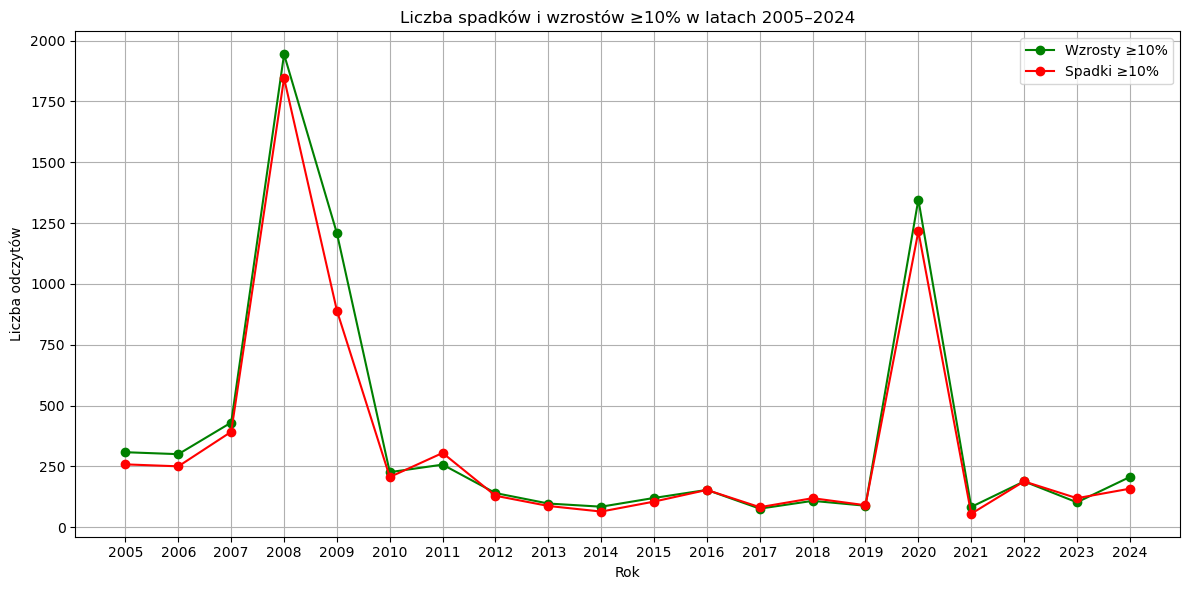

In [101]:
# wykres
plt.figure(figsize=(12, 6))
plt.plot(counts.index, counts.get('Wzrost', 0), label='Wzrosty ≥10%', marker='o', color='green')
plt.plot(counts.index, counts.get('Spadek', 0), label='Spadki ≥10%', marker='o', color='red')
plt.title('Liczba spadków i wzrostów ≥10% w latach 2005–2024')
plt.xlabel('Rok')
plt.ylabel('Liczba odczytów')
plt.xticks(ticks=counts.index)  # ustawiamy ticki osi X na każdy rok
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [103]:
# wczytujemy dane VIX
vix = pd.read_csv('Data/VIX_History.csv', parse_dates=["DATE"], date_format='%m/%d/%Y')
vix = vix.rename(columns={"DATE": "Date", "CLOSE": "VIX_Close"})
vix = vix[['Date', 'VIX_Close']]

In [105]:
# obliczamy średni roczny vix dla danego roku
vix['Year'] = vix['Date'].dt.year
vix_yearly = vix.groupby('Year')['VIX_Close'].mean().reindex(all_years) 

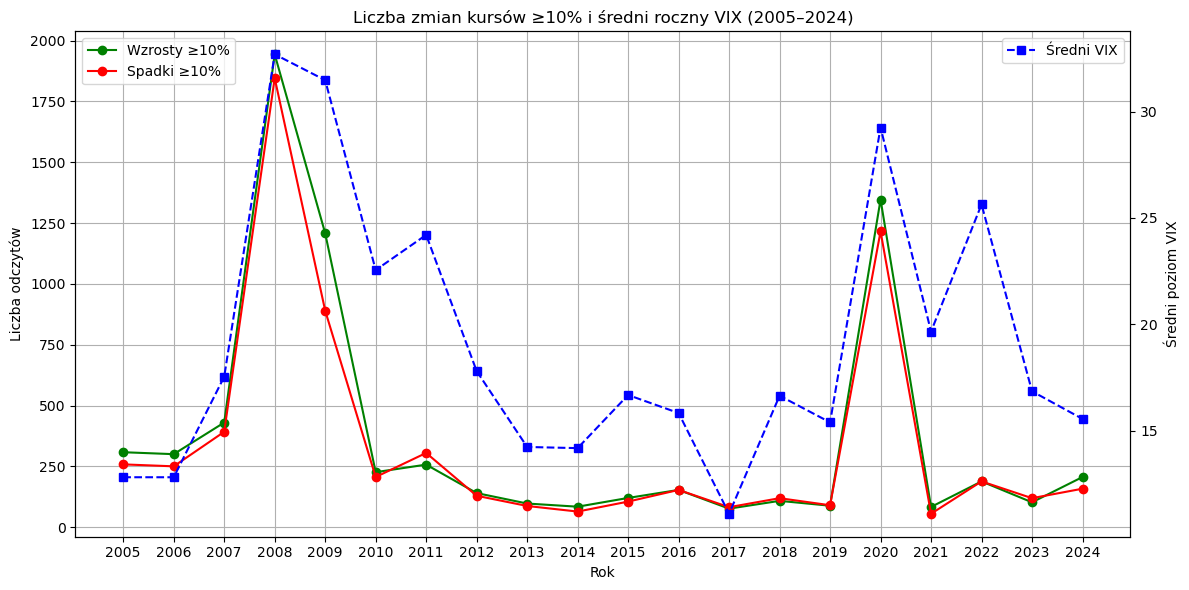

In [107]:
# wykres
fig, ax1 = plt.subplots(figsize=(12, 6))

# Oś lewa — liczba odczytów
ax1.plot(counts.index, counts.get('Wzrost', 0), label='Wzrosty ≥10%', marker='o', color='green')
ax1.plot(counts.index, counts.get('Spadek', 0), label='Spadki ≥10%', marker='o', color='red')
ax1.set_xlabel('Rok')
ax1.set_ylabel('Liczba odczytów')
ax1.set_xticks(all_years)
ax1.legend(loc='upper left')
ax1.grid(True)

# Oś prawa — VIX
ax2 = ax1.twinx()
ax2.plot(vix_yearly.index, vix_yearly.values, label='Średni VIX', color='blue', linestyle='--', marker='s')
ax2.set_ylabel('Średni poziom VIX')
ax2.legend(loc='upper right')

plt.title('Liczba zmian kursów ≥10% i średni roczny VIX (2005–2024)')
plt.tight_layout()
plt.show()

In [109]:
# łączymy ramki danych po kolumnie 'Date' (left join, bo chcemy zachować tylko te daty z 'wyniki')
wyniki_z_vix = pd.merge(wyniki, vix, on='Date', how='left')

# zostawiamy tylko te wiersze, gdzie VIX_Close <= 20.0
wyniki_filtered = wyniki_z_vix[wyniki_z_vix['VIX_Close'] <= 20.0].copy()

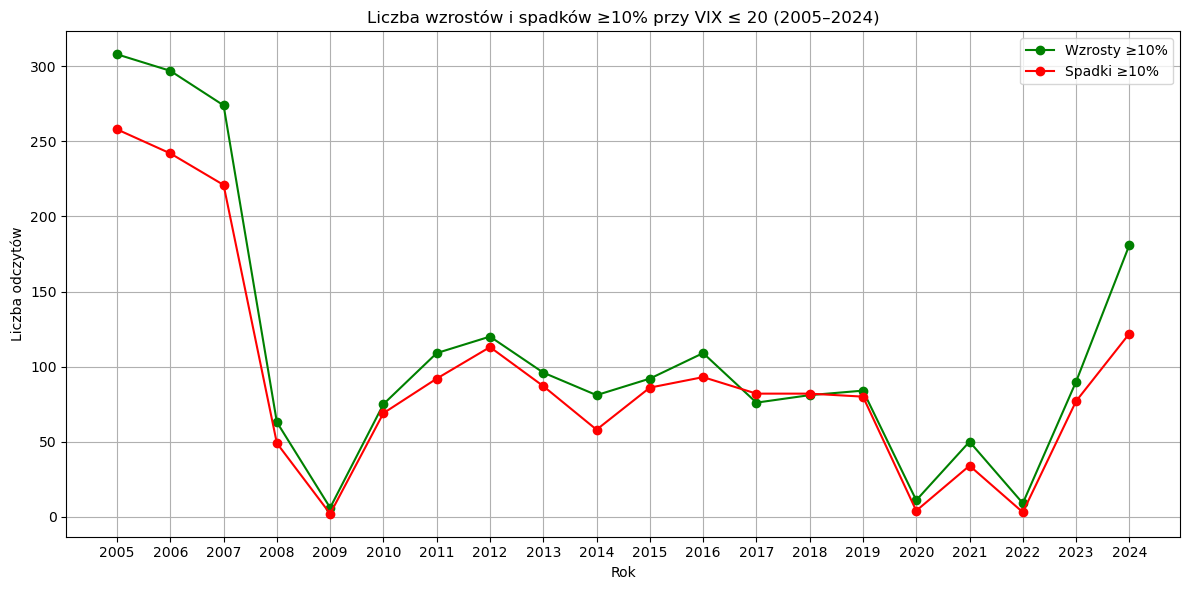

In [111]:
# grupujemy i liczymy wystąpienia
counts_filtered = wyniki_filtered.groupby(['Year_x', 'Change_Type']).size().unstack(fill_value=0)

# upewniamy się, że wszystkie lata są na osi X
all_years = list(range(2005, 2025))
counts_filtered = counts_filtered.reindex(all_years, fill_value=0)

# wykres
plt.figure(figsize=(12, 6))
plt.plot(counts_filtered.index, counts_filtered.get('Wzrost', 0), label='Wzrosty ≥10%', marker='o', color='green')
plt.plot(counts_filtered.index, counts_filtered.get('Spadek', 0), label='Spadki ≥10%', marker='o', color='red')
plt.title('Liczba wzrostów i spadków ≥10% przy VIX ≤ 20 (2005–2024)')
plt.xlabel('Rok')
plt.ylabel('Liczba odczytów')
plt.xticks(ticks=all_years)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

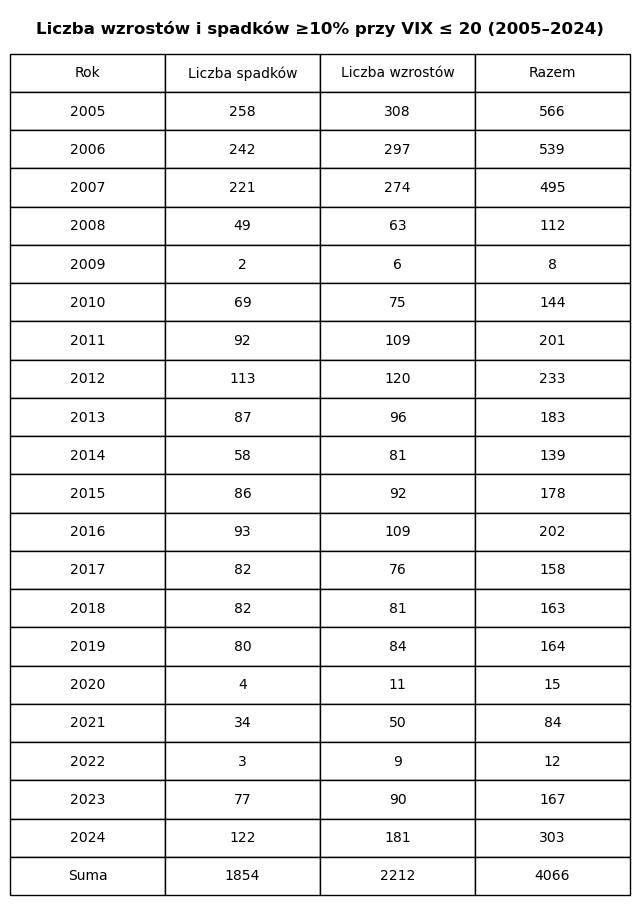

In [115]:
# przygotowujemy tabelę
tabela = wyniki_filtered.groupby(['Year_x', 'Change_Type']).size().unstack(fill_value=0)
tabela = tabela.reindex(range(2005, 2025), fill_value=0)
tabela['Razem'] = tabela.sum(axis=1)
tabela.loc['Suma'] = tabela.sum()
tabela.columns.name = None
tabela = tabela.rename(columns={'Wzrost': 'Liczba wzrostów', 'Spadek': 'Liczba spadków'})
tabela_reset = tabela.reset_index().rename(columns={'Year_x': 'Rok'})

# Rysowanie
fig, ax = plt.subplots(figsize=(8, len(tabela_reset) * 0.5 + 1))
ax.axis('off')

# Rysowanie tabeli — pozycjonowana manualnie
tbl = ax.table(
    cellText=tabela_reset.values,
    colLabels=tabela_reset.columns,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 0.95] 
)

# dodajemy tytuł jako tekst nad tabelą
ax.text(0.5, 0.97, "Liczba wzrostów i spadków ≥10% przy VIX ≤ 20 (2005–2024)",
        ha='center', va='bottom', fontsize=12, weight='bold')

# Styl tabeli
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)

plt.show()

In [123]:
# obliczamy procentowe zmiany względem Close
wyniki_filtered['Return_1Y'] = (wyniki_filtered['Close_After_1Y'] - wyniki_filtered['Close']) / wyniki_filtered['Close'] * 100
wyniki_filtered['Return_3Y'] = (wyniki_filtered['Close_After_3Y'] - wyniki_filtered['Close']) / wyniki_filtered['Close'] * 100
wyniki_filtered['Return_5Y'] = (wyniki_filtered['Close_After_5Y'] - wyniki_filtered['Close']) / wyniki_filtered['Close'] * 100

# dzielimy na wzrosty i spadki
wzrosty = wyniki_filtered[wyniki_filtered['Change_Type'] == 'Wzrost']
spadki = wyniki_filtered[wyniki_filtered['Change_Type'] == 'Spadek']

# tabele z procentowymi zmianami
tabela_wzrosty = wzrosty[['Return_1Y', 'Return_3Y', 'Return_5Y']]
tabela_spadki = spadki[['Return_1Y', 'Return_3Y', 'Return_5Y']]

In [125]:
tabela_wzrosty.describe()

,Return_1Y,Return_3Y,Return_5Y
count,1717.000000,1075.000000,714.000000
mean,155.481506,101.170457,79.316170
std,2526.257096,1994.423334,238.401976
min,-99.915903,-98.167608,-99.851485
25%,-42.857141,-59.927516,-50.975148
50%,-1.174583,-5.555550,26.908345
75%,28.295824,46.744822,120.777140
max,56670.663231,63850.197800,1904.362537


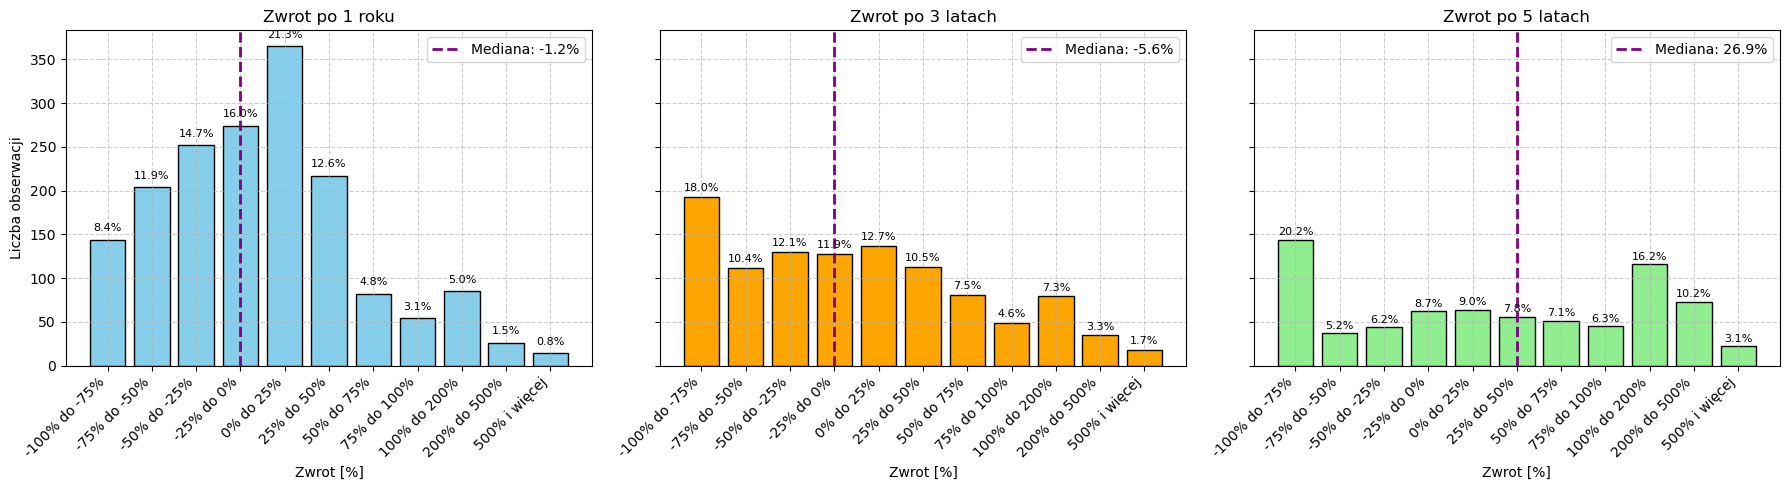

In [131]:
# koszyki (biny) jako kategorie zwrotów — ostatni bin od 500 do nieskończoności
bins = [-100, -75, -50, -25, 0, 25, 50, 75, 100, 200, 500, np.inf]
labels = [f'{bins[i]}% do {bins[i+1]}%' if bins[i+1] != np.inf else f'{bins[i]}% i więcej' for i in range(len(bins)-1)]

def prepare_hist_data(data):
    # dzielimy dane na koszyki
    categories = pd.cut(data.dropna(), bins=bins, labels=labels, right=False)
    counts = categories.value_counts().sort_index()
    return counts

def find_median_bin(median, bins):
    # znajdujemy indeks koszyka, w którym mieści się mediana
    for i in range(len(bins)-1):
        if bins[i] <= median < bins[i+1]:
            return i
    # jeśli mediana jest >= ostatniego binu, zwraca ostatni koszyk
    return len(bins) - 2

# nie filtrujemy danych - bierzemy wszystkie wartości
filtered_1Y = tabela_wzrosty['Return_1Y']
filtered_3Y = tabela_wzrosty['Return_3Y']
filtered_5Y = tabela_wzrosty['Return_5Y']

# przygotowanie danych
counts_1Y = prepare_hist_data(filtered_1Y)
counts_3Y = prepare_hist_data(filtered_3Y)
counts_5Y = prepare_hist_data(filtered_5Y)

# mediany
median_1Y = tabela_wzrosty['Return_1Y'].median()
median_3Y = tabela_wzrosty['Return_3Y'].median()
median_5Y = tabela_wzrosty['Return_5Y'].median()

# Wykres
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

hist_data = [
    (counts_1Y, 'Zwrot po 1 roku', 'skyblue', median_1Y),
    (counts_3Y, 'Zwrot po 3 latach', 'orange', median_3Y),
    (counts_5Y, 'Zwrot po 5 latach', 'lightgreen', median_5Y)
]

for ax, (counts, title, color, median) in zip(axes, hist_data):
    ax.bar(range(len(counts)), counts.values, color=color, edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel('Zwrot [%]')
    ax.set_xticks(range(len(counts))) 
    ax.set_xticklabels(counts.index, rotation=45, ha='right') 
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # znajdujemy pozycję mediany na osi X i rysujemy linię przerywaną
    median_bin_index = find_median_bin(median, bins)
    ax.axvline(median_bin_index, color='purple', linestyle='--', linewidth=2, label=f'Mediana: {median:.1f}%')
    
    # dodajemy procentowe wartości nad słupkami
    total = counts.sum()
    for i, val in enumerate(counts.values):
        pct = val / total * 100
        ax.text(i, val + max(counts.values)*0.02, f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)
    
    ax.legend()

# Etykieta osi Y tylko na pierwszym wykresie
axes[0].set_ylabel('Liczba obserwacji')

plt.tight_layout()
plt.show()

In [135]:
tabela_spadki.describe()

,Return_1Y,Return_3Y,Return_5Y
count,1.478000e+03,911.000000,591.000000
mean,8.077158e+03,822.234161,67.830093
std,2.052359e+05,2317.360769,218.226387
min,-9.914353e+01,-97.500000,-99.777778
25%,-2.464700e+01,-48.751363,-53.050674
50%,1.478169e+01,14.278754,23.914093
75%,5.812869e+01,87.369060,115.146816
max,7.866567e+06,19366.667219,2182.335601


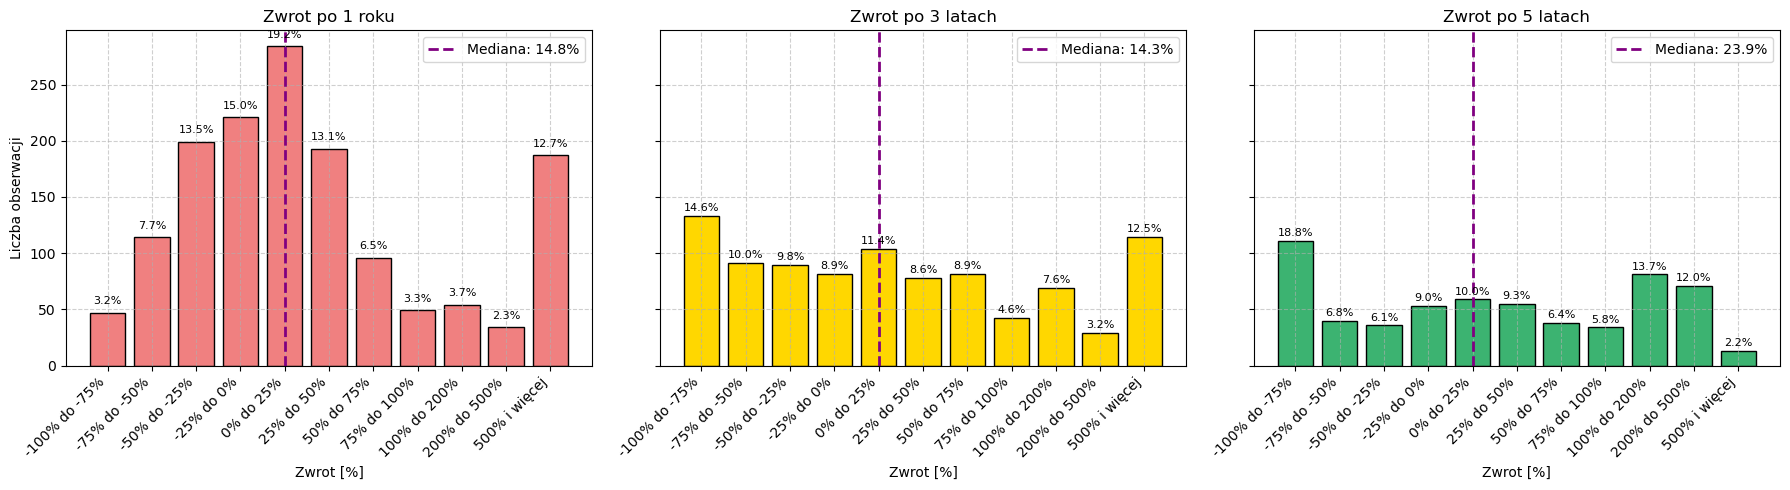

In [137]:
# koszyki (biny) jako kategorie zwrotów — ostatni bin od 500 do nieskończoności
bins = [-100, -75, -50, -25, 0, 25, 50, 75, 100, 200, 500, np.inf]
labels = [f'{bins[i]}% do {bins[i+1]}%' if bins[i+1] != np.inf else f'{bins[i]}% i więcej' for i in range(len(bins)-1)]

def prepare_hist_data(data):
    categories = pd.cut(data.dropna(), bins=bins, labels=labels, right=False)
    counts = categories.value_counts().sort_index()
    return counts

def find_median_bin(median, bins):
    for i in range(len(bins)-1):
        if bins[i] <= median < bins[i+1]:
            return i
    return len(bins) - 2

# Dane — bez filtrowania outlierów
filtered_1Y = tabela_spadki['Return_1Y']
filtered_3Y = tabela_spadki['Return_3Y']
filtered_5Y = tabela_spadki['Return_5Y']

# przygotowanie danych
counts_1Y = prepare_hist_data(filtered_1Y)
counts_3Y = prepare_hist_data(filtered_3Y)
counts_5Y = prepare_hist_data(filtered_5Y)

# mediany
median_1Y = filtered_1Y.median()
median_3Y = filtered_3Y.median()
median_5Y = filtered_5Y.median()

# Wykres
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

hist_data = [
    (counts_1Y, 'Zwrot po 1 roku', 'lightcoral', median_1Y),
    (counts_3Y, 'Zwrot po 3 latach', 'gold', median_3Y),
    (counts_5Y, 'Zwrot po 5 latach', 'mediumseagreen', median_5Y)
]

for ax, (counts, title, color, median) in zip(axes, hist_data):
    ax.bar(range(len(counts)), counts.values, color=color, edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel('Zwrot [%]')
    ax.set_xticks(range(len(counts)))
    ax.set_xticklabels(counts.index, rotation=45, ha='right')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # linia mediany
    median_bin_index = find_median_bin(median, bins)
    ax.axvline(median_bin_index, color='purple', linestyle='--', linewidth=2, label=f'Mediana: {median:.1f}%')
    
    # Procentowe etykiety nad słupkami
    total = counts.sum()
    for i, val in enumerate(counts.values):
        pct = val / total * 100
        ax.text(i, val + max(counts.values)*0.02, f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)
    
    ax.legend()

axes[0].set_ylabel('Liczba obserwacji')

plt.tight_layout()
plt.show()